### 1번 문제

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
from scipy.ndimage.interpolation import shift
import scipy.stats as sst
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

In [93]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [94]:
#BSM 옵션 이론가 계산
def bsprice(S, X, r, q, t_a, sigma, flag):
    d1 = (np.log(S/X) + (r - q + 0.5*sigma**2)*t_a) / (sigma*np.sqrt(t_a))
    d2 = d1 - sigma*np.sqrt(t_a)
    callOrPut = 1 if flag.lower()=='call' else -1
    nd1 = sst.norm.cdf(callOrPut*d1)
    nd2 = sst.norm.cdf(callOrPut*d2)
    price = callOrPut*(S*np.exp(-q*t_a)*nd1 - X*np.exp(-r*t_a)*nd2)
    return price

In [95]:
# Delta 계산 함수
def delta(S, X, r, q, t_a, sigma, flag):
    d1 = (np.log(S / X) + (r - q + 0.5 * sigma ** 2) * t_a) / (sigma * np.sqrt(t_a))
    return sst.norm.cdf(d1) if flag.lower() == 'call' else sst.norm.cdf(d1) - 1

In [96]:
def gamma(S, X, r, q, t_a, sigma, flag):
    # t_a는 연 단위 만기시간
    d1 = (np.log(S / X) + (r - q + 0.5 * sigma ** 2) * t_a) / (sigma * np.sqrt(t_a))
    return np.exp(-q * t_a) * sst.norm.pdf(d1) / (S * sigma * np.sqrt(t_a))

In [97]:
def hedge_cost(S, X, r, mu, q, sigma, t, nsim, M, flag, shares_per_opt, im_vol, optbs):
    
    t_a = t / 360
    # BS 이론가 계산
    theoretical_price = bsprice(S, X, r, q, t_a, im_vol, flag) * shares_per_opt

    # Monte Carlo 시뮬레이션을 이용해 만기 일수 만큼 일별 주가 path 생성
    z = np.random.randn(nsim, t) 
    schange = np.exp((mu - q - 0.5 * sigma ** 2) * (1/360) + sigma * np.sqrt(1/360) * z)
    stock_paths = np.zeros((nsim, t+1))
    stock_paths[:, 0] = S
    stock_paths[:, 1:] = S * np.cumprod(schange, axis=1)  # 누적 주가 경로
    
    # 2. 헷지 시점 정의
    hedge_points = list(range(0, t+1, M))
    if hedge_points[-1] != t:
        hedge_points.append(t)
    hedge_points = sorted(set(hedge_points))  # 중복 제거 및 정렬
    
    final_costs = np.zeros(nsim)
    
    for i in range(nsim):
        path = stock_paths[i,:]
        
        # 각 시뮬레이션별 누적비용 및 이전 델타 기록
        cumulative_cost = 0.0
        prev_delta = 0.0
        
        for idx, hp in enumerate(hedge_points):
            # 남은 만기 t_remaining = (t - hp)
            t_remaining = t - hp
            tau = t_remaining / 360
            
            # 헷지 시점의 주가
            s_current = path[hp]
            
            # 마지막 헷지 시점(만기)에서는 delta 결정 방식이 다름
            if hp == t:
                # 만기 시점 delta 결정
                # call: S_t >= X (ITM or ATM) -> delta=1 else 0
                # put: S_t >= X (ITM or ATM 이면) -> delta=0 else 1
                if flag.lower() == 'call':
                    if s_current >= X:
                        if optbs.lower() == 'sell':
                            current_delta = 1.0
                        else:
                            current_delta = -1.0
                    else:
                        current_delta = 0.0
                else: # put
                    if s_current >= X:
                        current_delta = 0.0
                    else:
                        if optbs.lower() == 'sell':
                            current_delta = 1.0
                        else:
                            current_delta = -1.0
            else:
                # 만기 전 일반 delta 계산
                current_delta = delta(s_current, X, r, q, tau, sigma, flag)
            
            # 계약 당 주식수 반영
            current_shares = current_delta * shares_per_opt
            prev_shares = prev_delta * shares_per_opt
            
            # 델타 차이만큼 주식 거래 필요
            delta_change = current_shares - prev_shares
            
            # 거래 비용 계산 (매수 시 양(+), 매도 시 음(-))
            # delta_change > 0 -> 매수
            # delta_change < 0 -> 매도
            if delta_change > 0:
                # 매수
                trade_cost = delta_change * s_current
            else:
                # 매도
                # 매도대금: (-delta_change)*s_current
                # 수수료: 매도대금의 0.1% = 0.001 * (-delta_change)*s_current
                # 실질 매도 순유입: (매도대금 - 수수료)
                # 비용 관점에서: 유입금(음수비용) + 수수료(양수비용)
                # trade_cost = - (매도순유입)
                proceeds = (-delta_change)*s_current
                fee = 0.001 * proceeds
                net_inflow = proceeds - fee
                trade_cost = -net_inflow  # 유입이므로 음수
                
            # 이자비용 계산
            # 이자비용 = 이전 누적비용 * r * M (hp=0 일 때는 이전비용=0이므로 0)
            if idx > 0:
                # 이전 헷지 시점과 현재 헷지 시점 사이의 일 수
                delta_t = hp - hedge_points[idx-1]
                interest_cost = cumulative_cost * r * (delta_t / 360)
            else:
                interest_cost = 0.0
          
            # 현재 누적비용 갱신
            cumulative_cost = cumulative_cost + trade_cost + interest_cost
            
            # 다음 헷지를 위해 현재 델타 갱신
            prev_delta = current_delta
        
        # 만기 시점 옵션 상태에 따른 최종 헷지코스트 계산
        s_final = path[-1]
        if flag.lower() == 'call':
            # ITM 또는 ATM: S_T >= X
            if s_final >= X:
                final_cost = cumulative_cost - X*shares_per_opt
            else:
                # OTM
                final_cost = cumulative_cost
        else:
            # put
            # ITM 또는 ATM: S_T <= X
            if s_final <= X:
                final_cost = X*shares_per_opt - cumulative_cost
            else:
                # OTM
                final_cost = cumulative_cost
        
        final_costs[i] = final_cost


    # Moneyness case 분류
    final_prices = stock_paths[:, -1]
    if flag.lower() == 'call':
        atm_case = final_costs[(final_prices < 1.01 * X) & (final_prices > 0.99 * X)]
        itm_case = final_costs[final_prices > X]
        otm_case = final_costs[final_prices < X]
    else:  # put
        atm_case = final_costs[(final_prices < 1.01 * X) & (final_prices > 0.99 * X)]
        itm_case = final_costs[final_prices < X]
        otm_case = final_costs[final_prices > X]


    # 옵션 매수매도 구분
    buyorsell = 1 if optbs.lower()=='sell' else -1

    # mean hedge cost
    mean_hedge_cost = np.mean(final_costs)
    mean_hedge_cost_atm = np.mean(atm_case)
    mean_hedge_cost_itm = np.mean(itm_case)
    mean_hedge_cost_otm = np.mean(otm_case)

    # hedging_pnl
    hedging_pnl = buyorsell * (theoretical_price-final_costs)
    hedging_pnl_atm = buyorsell * (theoretical_price-atm_case)
    hedging_pnl_itm = buyorsell * (theoretical_price-itm_case)
    hedging_pnl_otm = buyorsell * (theoretical_price-otm_case)

    # mean hedge pnl
    mean_hedging_pnl = np.mean(hedging_pnl)
    mean_hedging_pnl_atm = np.mean(hedging_pnl_atm)
    mean_hedging_pnl_itm = np.mean(hedging_pnl_itm)
    mean_hedging_pnl_otm = np.mean(hedging_pnl_otm)
    
    # hedge performance
    performance = np.std(theoretical_price - final_costs) / theoretical_price
    performance_atm = np.std(theoretical_price - atm_case) / theoretical_price
    performance_itm = np.std(theoretical_price - itm_case) / theoretical_price
    performance_otm = np.std(theoretical_price - otm_case) / theoretical_price

    # bias
    bias = np.abs((np.mean(final_costs) - theoretical_price))/theoretical_price
    bias_atm = np.abs((np.mean(atm_case) - theoretical_price))/theoretical_price
    bias_itm = np.abs((np.mean(itm_case) - theoretical_price))/theoretical_price
    bias_otm = np.abs((np.mean(otm_case) - theoretical_price))/theoretical_price

    results = []
    results.append([M, mean_hedge_cost, mean_hedge_cost_atm, mean_hedge_cost_itm, mean_hedge_cost_otm, mean_hedging_pnl, mean_hedging_pnl_atm, mean_hedging_pnl_itm, mean_hedging_pnl_otm, performance, performance_atm, performance_itm, performance_otm, bias, bias_atm, bias_itm, bias_otm])
    df = pd.DataFrame(results, columns=["Rebalancing Interval(days)", "mean_hedge_cost", "mean_hedge_cost_atm", "mean_hedge_cost_itm", "mean_hedge_cost_otm", "mean_hedging_pnl", "mean_hedging_pnl_atm", "mean_hedging_pnl_itm", "mean_hedging_pnl_otm", "performance", "performance_atm", "performance_itm", "performance_otm", "bias", "bias_atm", "bias_itm", "bias_otm"])

    
    return (stock_paths, 
            theoretical_price, 
            final_costs, 
            atm_case, 
            itm_case, 
            otm_case, 
            mean_hedge_cost, 
            mean_hedge_cost_atm, 
            mean_hedge_cost_itm, 
            mean_hedge_cost_otm, 
            hedging_pnl, 
            hedging_pnl_atm, 
            hedging_pnl_itm, 
            hedging_pnl_otm, 
            mean_hedging_pnl, 
            mean_hedging_pnl_atm, 
            mean_hedging_pnl_itm, 
            mean_hedging_pnl_otm, 
            performance, 
            performance_atm, 
            performance_itm, 
            performance_otm, 
            bias, 
            bias_atm, 
            bias_itm, 
            bias_otm, 
            df
    )


In [98]:
S, X, r, mu, q, sigma, t, nsim, M = 50000, 55000, 0.04, -0.13, 0, 0.4, 180, 1000, 2

im_vol = 0.46
flag = 'call'
optbs = 'sell'
shares_per_opt = 10000


In [99]:
(stock_paths, 
            theoretical_price, 
            final_costs, 
            atm_case, 
            itm_case, 
            otm_case, 
            mean_hedge_cost, 
            mean_hedge_cost_atm, 
            mean_hedge_cost_itm, 
            mean_hedge_cost_otm, 
            hedging_pnl, 
            hedging_pnl_atm, 
            hedging_pnl_itm, 
            hedging_pnl_otm, 
            mean_hedging_pnl, 
            mean_hedging_pnl_atm, 
            mean_hedging_pnl_itm, 
            mean_hedging_pnl_otm, 
            performance, 
            performance_atm, 
            performance_itm, 
            performance_otm, 
            bias, 
            bias_atm, 
            bias_itm, 
            bias_otm, 
            df
    )= hedge_cost(S, X, r, mu, q, sigma, t, nsim, M, flag, shares_per_opt, im_vol, optbs)

In [100]:
theoretical_price

49342976.190086775

In [101]:
df

,Rebalancing Interval(days),mean_hedge_cost,mean_hedge_cost_atm,mean_hedge_cost_itm,mean_hedge_cost_otm,mean_hedging_pnl,mean_hedging_pnl_atm,mean_hedging_pnl_itm,mean_hedging_pnl_otm,performance,performance_atm,performance_itm,performance_otm,bias,bias_atm,bias_itm,bias_otm
0,2,42490402.31,36851074.98,42149621.43,42603390.91,6852573.88,12491901.21,7193354.76,6739585.28,0.10,0.13,0.13,0.09,0.14,0.25,0.15,0.14


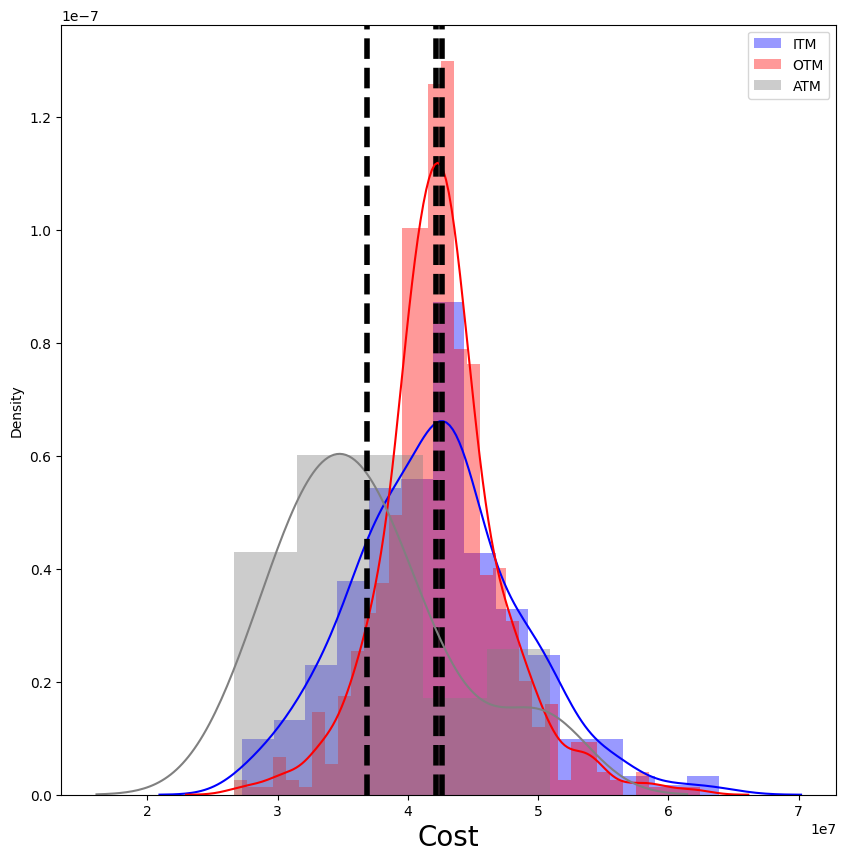

In [102]:
plt.figure(figsize=(10,10))
sns.distplot(itm_case,color='blue',label='ITM')
plt.axvline(x=itm_case.mean(),color='black',ls='--',lw=4)

sns.distplot(otm_case,color='red',label="OTM")
plt.axvline(x=otm_case.mean(),color='black',ls='--',lw=4)

sns.distplot(atm_case,color='gray',label="ATM")
plt.axvline(x=atm_case.mean(),color='black',ls='--',lw=4)

plt.xlabel("Cost",size=20)
plt.legend()
plt.show()

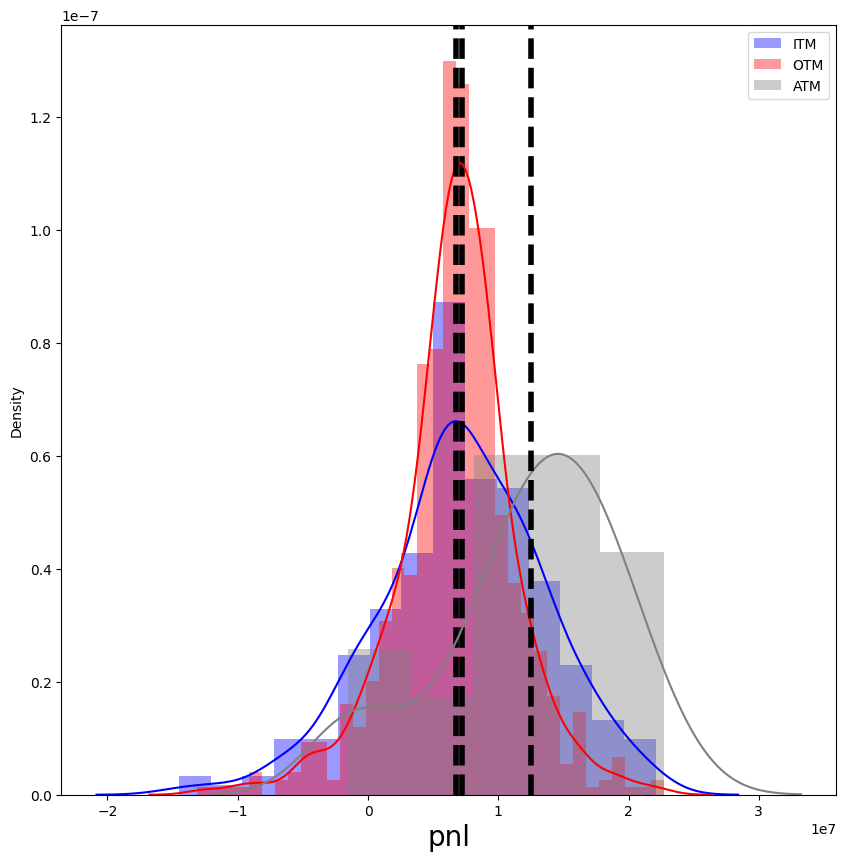

In [103]:
plt.figure(figsize=(10,10))
sns.distplot(hedging_pnl_itm,color='blue',label='ITM')
plt.axvline(x=hedging_pnl_itm.mean(),color='black',ls='--',lw=4)

sns.distplot(hedging_pnl_otm,color='red',label="OTM")
plt.axvline(x=hedging_pnl_otm.mean(),color='black',ls='--',lw=4)

sns.distplot(hedging_pnl_atm,color='gray',label="ATM")
plt.axvline(x=hedging_pnl_atm.mean(),color='black',ls='--',lw=4)

plt.xlabel("pnl",size=20)
plt.legend()
plt.show()

In [104]:
np.random.seed(42)

M_grid = [1, 2, 4, 5, 10, 20, 30, 60]  # 헷지 주기 리스트

# 결과를 저장할 리스트 초기화
results_all = []

# M_grid에 대한 루프 실행
for M_val in M_grid:
    print(f"Processing M = {M_val} days...")
    
    # hedge_cost 함수 호출
    (
       stock_paths, 
            theoretical_price, 
            final_costs, 
            atm_case, 
            itm_case, 
            otm_case, 
            mean_hedge_cost, 
            mean_hedge_cost_atm, 
            mean_hedge_cost_itm, 
            mean_hedge_cost_otm, 
            hedging_pnl, 
            hedging_pnl_atm, 
            hedging_pnl_itm, 
            hedging_pnl_otm, 
            mean_hedging_pnl, 
            mean_hedging_pnl_atm, 
            mean_hedging_pnl_itm, 
            mean_hedging_pnl_otm, 
            performance, 
            performance_atm, 
            performance_itm, 
            performance_otm, 
            bias, 
            bias_atm, 
            bias_itm, 
            bias_otm, 
            df
    ) = hedge_cost(
        S, X, r, mu, q, sigma, t, nsim, M_val, flag, shares_per_opt, im_vol, optbs
    )
    
    # DataFrame을 리스트에 추가
    results_all.append(df)

Processing M = 1 days...
Processing M = 2 days...
Processing M = 4 days...
Processing M = 5 days...
Processing M = 10 days...
Processing M = 20 days...
Processing M = 30 days...
Processing M = 60 days...


In [105]:
final_df = pd.concat(results_all, ignore_index=True)

In [106]:
final_df

,Rebalancing Interval(days),mean_hedge_cost,mean_hedge_cost_atm,mean_hedge_cost_itm,mean_hedge_cost_otm,mean_hedging_pnl,mean_hedging_pnl_atm,mean_hedging_pnl_itm,mean_hedging_pnl_otm,performance,performance_atm,performance_itm,performance_otm,bias,bias_atm,bias_itm,bias_otm
0,1,42819225.60,40281455.86,43094326.46,42728013.73,6523750.59,9061520.33,6248649.73,6614962.46,0.07,0.10,0.08,0.06,0.13,0.18,0.13,0.13
1,2,42470930.61,36798269.28,42640338.19,42423148.99,6872045.58,12544706.91,6702638.00,6919827.20,0.11,0.15,0.14,0.10,0.14,0.25,0.14,0.14
2,4,42251864.47,32268132.20,41765711.90,42400375.83,7091111.72,17074843.99,7577264.29,6942600.36,0.15,0.23,0.19,0.14,0.14,0.35,0.15,0.14
3,5,42479755.30,27714125.12,42563854.66,42450665.75,6863220.89,21628851.07,6779121.53,6892310.44,0.16,0.20,0.21,0.14,0.14,0.44,0.14,0.14
4,10,41943068.43,23728876.37,42742608.97,41698822.36,7399907.76,25614099.82,6600367.22,7644153.83,0.22,0.24,0.27,0.20,0.15,0.52,0.13,0.15
5,20,42236967.77,20881164.32,41620133.31,42396025.71,7106008.42,28461811.87,7722842.88,6946950.48,0.31,0.31,0.41,0.27,0.14,0.58,0.16,0.14
6,30,42441749.45,25147645.42,39974607.51,43220846.90,6901226.74,24195330.77,9368368.68,6122129.29,0.38,0.32,0.48,0.34,0.14,0.49,0.19,0.12
7,60,42377730.69,6518818.57,38782758.75,43333356.14,6965245.50,42824157.62,10560217.44,6009620.05,0.51,0.34,0.63,0.47,0.14,0.87,0.21,0.12


In [107]:
def hedge_cost_delta_band(S, X, r, mu, q, sigma, t, nsim, M, flag, shares_per_opt, im_vol, optbs, delta_band=0.05):
    t_a = t / 360
    # BS 이론가 계산
    theoretical_price = bsprice(S, X, r, q, t_a, im_vol, flag) * shares_per_opt

    # Monte Carlo 시뮬레이션을 이용해 만기 일 수 만큼 일별 주가 path 생성
    z = np.random.randn(nsim, t) 
    schange = np.exp((mu - q - 0.5 * sigma ** 2) * (1/360) + sigma * np.sqrt(1/360) * z)
    stock_paths = np.zeros((nsim, t+1))
    stock_paths[:, 0] = S
    stock_paths[:, 1:] = S * np.cumprod(schange, axis=1)  # 누적 주가 경로
    
    # 2. 헷지 시점 정의
    hedge_points = list(range(0, t+1, M))
    if hedge_points[-1] != t:
        hedge_points.append(t)
    hedge_points = sorted(set(hedge_points))  # 중복 제거 및 정렬
    
    final_costs = np.zeros(nsim)
    
    for i in range(nsim):
        path = stock_paths[i,:]
        
        # 각 시뮬레이션별 누적비용 및 이전 델타 기록
        cumulative_cost = 0.0
        prev_delta = 0.0
        
        for idx, hp in enumerate(hedge_points):
            t_remaining = t - hp
            tau = t_remaining / 360
            
            s_current = path[hp]

            # 만기 시점 델타 결정
            if hp == t:
                # 만기 시점 델타 결정
                if flag.lower() == 'call':
                    if s_current >= X:
                        # 콜 ITM
                        # 롱 포지션이면 +1, 숏 포지션이면 -1 (하지만 원본 로직은 다소 반대였으므로 재정비)
                        current_delta = 1.0 if optbs.lower() == 'sell' else -1.0
                    else:
                        current_delta = 0.0
                else: # put
                    if s_current >= X:
                        current_delta = 0.0
                    else:
                        # 풋 ITM
                        # 롱 포지션: -1, 숏 포지션: +1
                        current_delta = -1.0 if optbs.lower() == 'sell' else 1.0
            else:
                # 만기 전 일반 delta 계산
                current_delta = delta(s_current, X, r, q, tau, sigma, flag)
            
            # 밴드 체크: |current_delta - prev_delta|가 delta_band를 초과할 때만 리밸런싱
            if np.abs(current_delta - prev_delta) > delta_band or hp == t:
                # 계약 당 주식수 반영
                current_shares = current_delta * shares_per_opt
                prev_shares = prev_delta * shares_per_opt

                # 델타 차이만큼 주식 거래 필요
                delta_change = current_shares - prev_shares

                # 거래 비용 계산
                if delta_change > 0:
                    # 매수
                    trade_cost = delta_change * s_current
                else:
                    # 매도
                    proceeds = (-delta_change)*s_current
                    fee = 0.001 * proceeds
                    net_inflow = proceeds - fee
                    trade_cost = -net_inflow  # 유입이므로 음수
                
                # 이자비용 계산
                if idx > 0:
                    # 이전 헷지 시점과 현재 헷지 시점 사이의 일 수
                    delta_t = hp - hedge_points[idx-1]
                    interest_cost = cumulative_cost * r * (delta_t / 360)
                else:
                    interest_cost = 0.0

                # 누적비용 갱신
                cumulative_cost = cumulative_cost + trade_cost + interest_cost
                
                # 델타 업데이트(거래 수행 시만 prev_delta 갱신)
                prev_delta = current_delta
            else:
                # 밴드 내에 있으므로 거래 없음, 이자비용만 반영
                if idx > 0:
                    delta_t = hp - hedge_points[idx-1]
                    interest_cost = cumulative_cost * r * (delta_t / 360)
                else:
                    interest_cost = 0.0
                
                cumulative_cost = cumulative_cost + interest_cost
                # prev_delta 변화 없음(거래 안함)
        
        # 만기 시점 옵션 상태에 따른 최종 헷지코스트 계산
        s_final = path[-1]
        if flag.lower() == 'call':
            # ITM 또는 ATM: S_T >= X
            if s_final >= X:
                final_cost = cumulative_cost - X*shares_per_opt
            else:
                # OTM
                final_cost = cumulative_cost
        else:
            # put
            # ITM 또는 ATM: S_T <= X
            if s_final <= X:
                final_cost = X*shares_per_opt - cumulative_cost
            else:
                # OTM
                final_cost = cumulative_cost
        
        final_costs[i] = final_cost


    # Moneyness case 분류
    final_prices = stock_paths[:, -1]
    if flag.lower() == 'call':
        atm_case = final_costs[(final_prices < 1.01 * X) & (final_prices > 0.99 * X)]
        itm_case = final_costs[final_prices > X]
        otm_case = final_costs[final_prices < X]
    else:  # put
        atm_case = final_costs[(final_prices < 1.01 * X) & (final_prices > 0.99 * X)]
        itm_case = final_costs[final_prices < X]
        otm_case = final_costs[final_prices > X]


    # 옵션 매수매도 구분
    buyorsell = 1 if optbs.lower()=='sell' else -1

    # mean hedge cost
    mean_hedge_cost = np.mean(final_costs)
    mean_hedge_cost_atm = np.mean(atm_case) if len(atm_case)>0 else np.nan
    mean_hedge_cost_itm = np.mean(itm_case) if len(itm_case)>0 else np.nan
    mean_hedge_cost_otm = np.mean(otm_case) if len(otm_case)>0 else np.nan

    # hedging_pnl
    hedging_pnl = buyorsell * (theoretical_price-final_costs)
    hedging_pnl_atm = buyorsell * (theoretical_price-atm_case) if len(atm_case)>0 else np.array([np.nan])
    hedging_pnl_itm = buyorsell * (theoretical_price-itm_case) if len(itm_case)>0 else np.array([np.nan])
    hedging_pnl_otm = buyorsell * (theoretical_price-otm_case) if len(otm_case)>0 else np.array([np.nan])

    # mean hedge pnl
    mean_hedging_pnl = np.mean(hedging_pnl)
    mean_hedging_pnl_atm = np.mean(hedging_pnl_atm) if len(hedging_pnl_atm)>0 else np.nan
    mean_hedging_pnl_itm = np.mean(hedging_pnl_itm) if len(hedging_pnl_itm)>0 else np.nan
    mean_hedging_pnl_otm = np.mean(hedging_pnl_otm) if len(hedging_pnl_otm)>0 else np.nan
    
    # hedge performance
    performance = np.std(theoretical_price - final_costs) / theoretical_price
    performance_atm = np.std(theoretical_price - atm_case) / theoretical_price if len(atm_case)>0 else np.nan
    performance_itm = np.std(theoretical_price - itm_case) / theoretical_price if len(itm_case)>0 else np.nan
    performance_otm = np.std(theoretical_price - otm_case) / theoretical_price if len(otm_case)>0 else np.nan

    # bias
    bias = np.abs((np.mean(final_costs) - theoretical_price))/theoretical_price
    bias_atm = np.abs((np.mean(atm_case) - theoretical_price))/theoretical_price if len(atm_case)>0 else np.nan
    bias_itm = np.abs((np.mean(itm_case) - theoretical_price))/theoretical_price if len(itm_case)>0 else np.nan
    bias_otm = np.abs((np.mean(otm_case) - theoretical_price))/theoretical_price if len(otm_case)>0 else np.nan

    results = []
    results.append([M, mean_hedge_cost, mean_hedge_cost_atm, mean_hedge_cost_itm, mean_hedge_cost_otm, 
                    mean_hedging_pnl, mean_hedging_pnl_atm, mean_hedging_pnl_itm, mean_hedging_pnl_otm, 
                    performance, performance_atm, performance_itm, performance_otm, 
                    bias, bias_atm, bias_itm, bias_otm])
    df = pd.DataFrame(results, columns=["Rebalancing Interval(days)", "mean_hedge_cost", 
                                        "mean_hedge_cost_atm", "mean_hedge_cost_itm", "mean_hedge_cost_otm", 
                                        "mean_hedging_pnl", "mean_hedging_pnl_atm", "mean_hedging_pnl_itm", "mean_hedging_pnl_otm", 
                                        "performance", "performance_atm", "performance_itm", "performance_otm", 
                                        "bias", "bias_atm", "bias_itm", "bias_otm"])

    return (stock_paths, 
            theoretical_price, 
            final_costs, 
            atm_case, 
            itm_case, 
            otm_case, 
            mean_hedge_cost, 
            mean_hedge_cost_atm, 
            mean_hedge_cost_itm, 
            mean_hedge_cost_otm, 
            hedging_pnl, 
            hedging_pnl_atm, 
            hedging_pnl_itm, 
            hedging_pnl_otm, 
            mean_hedging_pnl, 
            mean_hedging_pnl_atm, 
            mean_hedging_pnl_itm, 
            mean_hedging_pnl_otm, 
            performance, 
            performance_atm, 
            performance_itm, 
            performance_otm, 
            bias, 
            bias_atm, 
            bias_itm, 
            bias_otm, 
            df
    )


In [108]:
(stock_paths, 
            theoretical_price, 
            final_costs, 
            atm_case, 
            itm_case, 
            otm_case, 
            mean_hedge_cost, 
            mean_hedge_cost_atm, 
            mean_hedge_cost_itm, 
            mean_hedge_cost_otm, 
            hedging_pnl, 
            hedging_pnl_atm, 
            hedging_pnl_itm, 
            hedging_pnl_otm, 
            mean_hedging_pnl, 
            mean_hedging_pnl_atm, 
            mean_hedging_pnl_itm, 
            mean_hedging_pnl_otm, 
            performance, 
            performance_atm, 
            performance_itm, 
            performance_otm, 
            bias, 
            bias_atm, 
            bias_itm, 
            bias_otm, 
            df
    )= hedge_cost_delta_band(S, X, r, mu, q, sigma, t, nsim, M, flag, shares_per_opt, im_vol, optbs)

In [109]:
df

,Rebalancing Interval(days),mean_hedge_cost,mean_hedge_cost_atm,mean_hedge_cost_itm,mean_hedge_cost_otm,mean_hedging_pnl,mean_hedging_pnl_atm,mean_hedging_pnl_itm,mean_hedging_pnl_otm,performance,performance_atm,performance_itm,performance_otm,bias,bias_atm,bias_itm,bias_otm
0,2,42458651.73,35290401.63,42402465.67,42477081.96,6884324.46,14052574.56,6940510.52,6865894.23,0.12,0.16,0.15,0.11,0.14,0.28,0.14,0.14


In [110]:
# 결과를 저장할 리스트 초기화
results_all_deltaband = []

# M_grid에 대한 루프 실행
for M_val in M_grid:
    print(f"Processing M = {M_val} days...")
    
    # hedge_cost 함수 호출
    (
       stock_paths, 
            theoretical_price, 
            final_costs, 
            atm_case, 
            itm_case, 
            otm_case, 
            mean_hedge_cost, 
            mean_hedge_cost_atm, 
            mean_hedge_cost_itm, 
            mean_hedge_cost_otm, 
            hedging_pnl, 
            hedging_pnl_atm, 
            hedging_pnl_itm, 
            hedging_pnl_otm, 
            mean_hedging_pnl, 
            mean_hedging_pnl_atm, 
            mean_hedging_pnl_itm, 
            mean_hedging_pnl_otm, 
            performance, 
            performance_atm, 
            performance_itm, 
            performance_otm, 
            bias, 
            bias_atm, 
            bias_itm, 
            bias_otm, 
            df
    ) = hedge_cost_delta_band(
        S, X, r, mu, q, sigma, t, nsim, M_val, flag, shares_per_opt, im_vol, optbs
    )
    
    # DataFrame을 리스트에 추가
    results_all_deltaband.append(df)

Processing M = 1 days...
Processing M = 2 days...
Processing M = 4 days...
Processing M = 5 days...
Processing M = 10 days...
Processing M = 20 days...
Processing M = 30 days...
Processing M = 60 days...


In [111]:
final_df_deltaband = pd.concat(results_all_deltaband, ignore_index=True)

In [112]:
final_df_deltaband

,Rebalancing Interval(days),mean_hedge_cost,mean_hedge_cost_atm,mean_hedge_cost_itm,mean_hedge_cost_otm,mean_hedging_pnl,mean_hedging_pnl_atm,mean_hedging_pnl_itm,mean_hedging_pnl_otm,performance,performance_atm,performance_itm,performance_otm,bias,bias_atm,bias_itm,bias_otm
0,1,42513866.30,37026777.84,42438056.68,42537283.93,6829109.89,12316198.35,6904919.51,6805692.26,0.10,0.15,0.13,0.09,0.14,0.25,0.14,0.14
1,2,42136733.94,34075078.17,41594220.54,42317571.74,7206242.25,15267898.02,7748755.65,7025404.45,0.12,0.17,0.15,0.11,0.15,0.31,0.16,0.14
2,4,42073625.16,34543922.90,41612646.46,42208996.65,7269351.03,14799053.29,7730329.73,7133979.54,0.16,0.23,0.21,0.14,0.15,0.30,0.16,0.14
3,5,42208276.37,34184253.06,42014868.07,42269352.68,7134699.82,15158723.13,7328108.12,7073623.51,0.17,0.27,0.21,0.16,0.14,0.31,0.15,0.14
4,10,42325115.55,22829470.07,41289854.95,42690748.86,7017860.64,26513506.12,8053121.24,6652227.33,0.24,0.24,0.31,0.20,0.14,0.54,0.16,0.13
5,20,42549557.11,24855537.77,40115177.31,43335256.41,6793419.08,24487438.42,9227798.88,6007719.78,0.33,0.45,0.42,0.29,0.14,0.50,0.19,0.12
6,30,42013880.02,21667178.93,41109252.15,42287153.02,7329096.17,27675797.26,8233724.04,7055823.17,0.38,0.44,0.51,0.33,0.15,0.56,0.17,0.14
7,60,42049940.21,8230759.47,41960988.66,42076210.87,7293035.98,41112216.72,7381987.53,7266765.32,0.50,0.43,0.64,0.45,0.15,0.83,0.15,0.15


In [113]:
def hedge_cost_delta_gamma_band(S, X, r, mu, q, sigma, t, nsim, M, flag, shares_per_opt, im_vol, optbs, delta_band=0.05, gamma_scale=10.0):
    t_a = t / 360
    # BS 이론가 계산
    theoretical_price = bsprice(S, X, r, q, t_a, im_vol, flag) * shares_per_opt

    # Monte Carlo 시뮬레이션을 이용해 만기 일 수 만큼 일별 주가 path 생성
    z = np.random.randn(nsim, t) 
    schange = np.exp((mu - q - 0.5 * sigma ** 2) * (1/360) + sigma * np.sqrt(1/360) * z)
    stock_paths = np.zeros((nsim, t+1))
    stock_paths[:, 0] = S
    stock_paths[:, 1:] = S * np.cumprod(schange, axis=1)  # 누적 주가 경로
    
    # 헷지 시점 정의
    hedge_points = list(range(0, t+1, M))
    if hedge_points[-1] != t:
        hedge_points.append(t)
    hedge_points = sorted(set(hedge_points))  # 중복 제거 및 정렬
    
    final_costs = np.zeros(nsim)
    
    for i in range(nsim):
        path = stock_paths[i,:]
        
        # 각 시뮬레이션별 누적비용 및 이전 델타 기록
        cumulative_cost = 0.0
        prev_delta = 0.0
        
        for idx, hp in enumerate(hedge_points):
            t_remaining = t - hp
            tau = t_remaining / 360
            s_current = path[hp]

            # 만기 시점 델타 결정
            if hp == t:
                if flag.lower() == 'call':
                    if s_current >= X:
                        # 콜 ITM
                        current_delta = 1.0 if optbs.lower() == 'sell' else -1.0
                    else:
                        current_delta = 0.0
                else: # put
                    if s_current >= X:
                        current_delta = 0.0
                    else:
                        # 풋 ITM
                        current_delta = -1.0 if optbs.lower() == 'sell' else 1.0
                # 만기는 항상 최종 조정이 필요하므로 밴드 체크 없이 리밸런싱
                effective_delta_band = 0.0
            else:
                # 만기 전 일반 delta/gamma 계산
                current_delta = delta(s_current, X, r, q, tau, sigma, flag)
                current_gamma = gamma(s_current, X, r, q, tau, sigma, flag)
                
                # 감마가 클수록 밴드를 줄여서 더 자주 리밸런싱
                # 예: effective_band = delta_band / (1 + gamma_scale * gamma)
                effective_delta_band = delta_band / (1.0 + gamma_scale * current_gamma)
            
            # 델타 조정 필요성 판단
            if (np.abs(current_delta - prev_delta) > effective_delta_band) or (hp == t):
                # 계약 당 주식수 반영
                current_shares = current_delta * shares_per_opt
                prev_shares = prev_delta * shares_per_opt

                # 델타 차이만큼 주식 거래 필요
                delta_change = current_shares - prev_shares

                # 거래 비용 계산
                if delta_change > 0:
                    # 매수
                    trade_cost = delta_change * s_current
                else:
                    # 매도
                    proceeds = (-delta_change)*s_current
                    fee = 0.001 * proceeds
                    net_inflow = proceeds - fee
                    trade_cost = -net_inflow  # 유입이므로 음수
                
                # 이자비용 계산
                if idx > 0:
                    # 이전 헷지 시점과 현재 헷지 시점 사이의 일 수
                    delta_t = hp - hedge_points[idx-1]
                    interest_cost = cumulative_cost * r * (delta_t / 360)
                else:
                    interest_cost = 0.0

                # 누적비용 갱신
                cumulative_cost = cumulative_cost + trade_cost + interest_cost
                
                # 델타 업데이트(거래 수행 시만 prev_delta 갱신)
                prev_delta = current_delta
            else:
                # 밴드 내에 있으므로 거래 없음, 이자비용만 반영
                if idx > 0:
                    delta_t = hp - hedge_points[idx-1]
                    interest_cost = cumulative_cost * r * (delta_t / 360)
                else:
                    interest_cost = 0.0
                cumulative_cost = cumulative_cost + interest_cost
                # prev_delta 변화 없음(거래 안함)
        
        # 만기 시점 옵션 상태에 따른 최종 헷지코스트 계산
        s_final = path[-1]
        if flag.lower() == 'call':
            # ITM 또는 ATM: S_T >= X
            if s_final >= X:
                final_cost = cumulative_cost - X*shares_per_opt
            else:
                # OTM
                final_cost = cumulative_cost
        else:
            # put
            # ITM 또는 ATM: S_T <= X
            if s_final <= X:
                final_cost = X*shares_per_opt - cumulative_cost
            else:
                # OTM
                final_cost = cumulative_cost
        
        final_costs[i] = final_cost


    # Moneyness case 분류
    final_prices = stock_paths[:, -1]
    if flag.lower() == 'call':
        atm_case = final_costs[(final_prices < 1.01 * X) & (final_prices > 0.99 * X)]
        itm_case = final_costs[final_prices > X]
        otm_case = final_costs[final_prices < X]
    else:  # put
        atm_case = final_costs[(final_prices < 1.01 * X) & (final_prices > 0.99 * X)]
        itm_case = final_costs[final_prices < X]
        otm_case = final_costs[final_prices > X]

    # 옵션 매수매도 구분
    buyorsell = 1 if optbs.lower()=='sell' else -1

    # mean hedge cost
    mean_hedge_cost = np.mean(final_costs)
    mean_hedge_cost_atm = np.mean(atm_case) if len(atm_case)>0 else np.nan
    mean_hedge_cost_itm = np.mean(itm_case) if len(itm_case)>0 else np.nan
    mean_hedge_cost_otm = np.mean(otm_case) if len(otm_case)>0 else np.nan

    # hedging_pnl
    hedging_pnl = buyorsell * (theoretical_price-final_costs)
    hedging_pnl_atm = buyorsell * (theoretical_price - atm_case) if len(atm_case)>0 else np.array([np.nan])
    hedging_pnl_itm = buyorsell * (theoretical_price - itm_case) if len(itm_case)>0 else np.array([np.nan])
    hedging_pnl_otm = buyorsell * (theoretical_price - otm_case) if len(otm_case)>0 else np.array([np.nan])

    # mean hedge pnl
    mean_hedging_pnl = np.mean(hedging_pnl)
    mean_hedging_pnl_atm = np.mean(hedging_pnl_atm) if len(hedging_pnl_atm)>0 else np.nan
    mean_hedging_pnl_itm = np.mean(hedging_pnl_itm) if len(hedging_pnl_itm)>0 else np.nan
    mean_hedging_pnl_otm = np.mean(hedging_pnl_otm) if len(hedging_pnl_otm)>0 else np.nan
    
    # hedge performance
    performance = np.std(theoretical_price - final_costs) / theoretical_price
    performance_atm = np.std(theoretical_price - atm_case) / theoretical_price if len(atm_case)>0 else np.nan
    performance_itm = np.std(theoretical_price - itm_case) / theoretical_price if len(itm_case)>0 else np.nan
    performance_otm = np.std(theoretical_price - otm_case) / theoretical_price if len(otm_case)>0 else np.nan

    # bias
    bias = np.abs((np.mean(final_costs) - theoretical_price))/theoretical_price
    bias_atm = np.abs((np.mean(atm_case) - theoretical_price))/theoretical_price if len(atm_case)>0 else np.nan
    bias_itm = np.abs((np.mean(itm_case) - theoretical_price))/theoretical_price if len(itm_case)>0 else np.nan
    bias_otm = np.abs((np.mean(otm_case) - theoretical_price))/theoretical_price if len(otm_case)>0 else np.nan

    results = []
    results.append([M, mean_hedge_cost, mean_hedge_cost_atm, mean_hedge_cost_itm, mean_hedge_cost_otm, 
                    mean_hedging_pnl, mean_hedging_pnl_atm, mean_hedging_pnl_itm, mean_hedging_pnl_otm, 
                    performance, performance_atm, performance_itm, performance_otm, 
                    bias, bias_atm, bias_itm, bias_otm])
    df = pd.DataFrame(results, columns=["Rebalancing Interval(days)", "mean_hedge_cost", 
                                        "mean_hedge_cost_atm", "mean_hedge_cost_itm", "mean_hedge_cost_otm", 
                                        "mean_hedging_pnl", "mean_hedging_pnl_atm", "mean_hedging_pnl_itm", "mean_hedging_pnl_otm", 
                                        "performance", "performance_atm", "performance_itm", "performance_otm", 
                                        "bias", "bias_atm", "bias_itm", "bias_otm"])

    return (stock_paths, 
            theoretical_price, 
            final_costs, 
            atm_case, 
            itm_case, 
            otm_case, 
            mean_hedge_cost, 
            mean_hedge_cost_atm, 
            mean_hedge_cost_itm, 
            mean_hedge_cost_otm, 
            hedging_pnl, 
            hedging_pnl_atm, 
            hedging_pnl_itm, 
            hedging_pnl_otm, 
            mean_hedging_pnl, 
            mean_hedging_pnl_atm, 
            mean_hedging_pnl_itm, 
            mean_hedging_pnl_otm, 
            performance, 
            performance_atm, 
            performance_itm, 
            performance_otm, 
            bias, 
            bias_atm, 
            bias_itm, 
            bias_otm, 
            df
    )


In [114]:
# 결과를 저장할 리스트 초기화
results_all_deltagammaband = []

# M_grid에 대한 루프 실행
for M_val in M_grid:
    print(f"Processing M = {M_val} days...")
    
    # hedge_cost 함수 호출
    (
       stock_paths, 
            theoretical_price, 
            final_costs, 
            atm_case, 
            itm_case, 
            otm_case, 
            mean_hedge_cost, 
            mean_hedge_cost_atm, 
            mean_hedge_cost_itm, 
            mean_hedge_cost_otm, 
            hedging_pnl, 
            hedging_pnl_atm, 
            hedging_pnl_itm, 
            hedging_pnl_otm, 
            mean_hedging_pnl, 
            mean_hedging_pnl_atm, 
            mean_hedging_pnl_itm, 
            mean_hedging_pnl_otm, 
            performance, 
            performance_atm, 
            performance_itm, 
            performance_otm, 
            bias, 
            bias_atm, 
            bias_itm, 
            bias_otm, 
            df
    ) = hedge_cost_delta_band(
        S, X, r, mu, q, sigma, t, nsim, M_val, flag, shares_per_opt, im_vol, optbs
    )
    
    # DataFrame을 리스트에 추가
    results_all_deltagammaband.append(df)

Processing M = 1 days...
Processing M = 2 days...
Processing M = 4 days...
Processing M = 5 days...
Processing M = 10 days...
Processing M = 20 days...
Processing M = 30 days...
Processing M = 60 days...


In [115]:
final_df_deltagammaband = pd.concat(results_all_deltagammaband, ignore_index=True)

In [116]:
final_df_deltagammaband

,Rebalancing Interval(days),mean_hedge_cost,mean_hedge_cost_atm,mean_hedge_cost_itm,mean_hedge_cost_otm,mean_hedging_pnl,mean_hedging_pnl_atm,mean_hedging_pnl_itm,mean_hedging_pnl_otm,performance,performance_atm,performance_itm,performance_otm,bias,bias_atm,bias_itm,bias_otm
0,1,42244464.22,35884620.37,41760297.94,42382619.63,7098511.97,13458355.82,7582678.25,6960356.56,0.10,0.10,0.12,0.10,0.14,0.27,0.15,0.14
1,2,42301913.16,35447595.30,41581665.56,42534374.02,7041063.03,13895380.89,7761310.63,6808602.17,0.12,0.21,0.15,0.11,0.14,0.28,0.16,0.14
2,4,42184995.21,32899582.41,42488827.52,42096785.83,7157980.98,16443393.78,6854148.67,7246190.36,0.16,0.22,0.20,0.15,0.15,0.33,0.14,0.15
3,5,42549281.32,31530887.18,42084245.29,42694528.79,6793694.87,17812089.01,7258730.90,6648447.40,0.18,0.23,0.22,0.16,0.14,0.36,0.15,0.13
4,10,41558565.94,26139647.27,41103351.77,41708689.77,7784410.25,23203328.92,8239624.42,7634286.42,0.22,0.26,0.26,0.21,0.16,0.47,0.17,0.15
5,20,42738255.33,23298857.13,42363356.71,42843995.97,6604720.86,26044119.06,6979619.48,6498980.22,0.31,0.30,0.42,0.27,0.13,0.53,0.14,0.13
6,30,42816851.59,21242782.20,42281616.44,42984024.77,6526124.60,28100193.99,7061359.75,6358951.42,0.40,0.30,0.52,0.35,0.13,0.57,0.14,0.13
7,60,43112490.43,9374469.85,41502620.27,43666424.24,6230485.76,39968506.34,7840355.92,5676551.95,0.54,0.41,0.68,0.48,0.13,0.81,0.16,0.12


In [117]:
from pathlib import Path
# OUTPUT_PATH = Path(r"C:\Users\USER\OneDrive\바탕 화면\임우섭\01. 카이스트\02. 입학후\03. 24-2학기\08. 파생상품 거래전략\04. 과제\02. Term project")

CWD_PATH = Path.cwd()
WS_PATH = CWD_PATH.parent
OUTPUT_PATH = WS_PATH / "output"
DATA_PATH = WS_PATH / "data"

In [118]:
df = pd.read_parquet(OUTPUT_PATH / 'option_data_targets_20220101-20241204.parquet')

In [119]:
df 

,underlying_full,ticker,trade_date,expiration,expiration_date,call_or_put,strike,close_price,open_price,high_price,...,udly_low,udly_close,udly_volume,udly_return,ret_vol_120d_ann,close_strike_diff,atm,itm,otm,moneyness
154,KT,030200,2022-01-03,202201,2022-01-13,C,30000.00,800.00,810.00,870.00,...,30250,30350,1027133,-0.01,NaN,350.00,True,False,False,-0.01
155,KT,030200,2022-01-03,202201,2022-01-13,C,31000.00,330.00,310.00,330.00,...,30250,30350,1027133,-0.01,NaN,-650.00,False,False,True,0.02
156,KT,030200,2022-01-03,202201,2022-01-13,C,32000.00,100.00,100.00,110.00,...,30250,30350,1027133,-0.01,NaN,-1650.00,False,False,True,0.05
157,KT,030200,2022-01-03,202201,2022-01-13,C,33000.00,50.00,40.00,110.00,...,30250,30350,1027133,-0.01,NaN,-2650.00,False,False,True,0.08
158,KT,030200,2022-01-03,202201,2022-01-13,C,34000.00,60.00,40.00,70.00,...,30250,30350,1027133,-0.01,NaN,-3650.00,False,False,True,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5668711,현대제철,004020,2024-12-04,202412,2024-12-12,P,19500.00,100.00,90.00,120.00,...,20850,21450,664736,-0.02,0.33,1950.00,False,False,True,-0.10
5668712,현대제철,004020,2024-12-04,202412,2024-12-12,P,20000.00,160.00,160.00,160.00,...,20850,21450,664736,-0.02,0.33,1450.00,False,False,True,-0.07
5668713,현대제철,004020,2024-12-04,202412,2024-12-12,P,21000.00,430.00,490.00,540.00,...,20850,21450,664736,-0.02,0.33,450.00,True,False,False,-0.02
5668714,현대제철,004020,2024-12-04,202412,2024-12-12,P,22000.00,950.00,1060.00,1240.00,...,20850,21450,664736,-0.02,0.33,-550.00,False,True,False,0.03


In [120]:
print(df.columns)

Index(['underlying_full', 'ticker', 'trade_date', 'expiration',
       'expiration_date', 'call_or_put', 'strike', 'close_price', 'open_price',
       'high_price', 'low_price', 'im_vol', 'next_day_base_price',
       'trade_volume', 'trade_value', 'open_interest_quantity', 'udly_open',
       'udly_high', 'udly_low', 'udly_close', 'udly_volume', 'udly_return',
       'ret_vol_120d_ann', 'close_strike_diff', 'atm', 'itm', 'otm',
       'moneyness'],
      dtype='object')


In [121]:
# df.to_excel(r"C:\Users\USER\OneDrive\바탕 화면\임우섭\01. 카이스트\02. 입학후\03. 24-2학기\08. 파생상품 거래전략\04. 과제\02. Term project\output.xlsx", index=False)

In [122]:
samsung_data = df[df['underlying_full'] == '삼성전자']
# 각 trade_date 기준으로 첫 번째 행에서 udly_close 값 추출
samsumg_df = samsung_data.groupby('trade_date').first().reset_index()[['trade_date', 'udly_close', 'udly_return']]
samsumg_df

,trade_date,udly_close,udly_return
0,2022-01-03,78600,0.00
1,2022-01-04,78700,0.00
2,2022-01-05,77400,-0.02
3,2022-01-06,76900,-0.01
4,2022-01-07,78300,0.02
...,...,...,...
713,2024-11-28,55500,-0.01
714,2024-11-29,54200,-0.02
715,2024-12-02,53600,-0.01
716,2024-12-03,53600,0.00


어차피 옵션데이터 안 쓴다... 걍 yfinance에서 불러오자

In [123]:
# import yfinance as yf
from arch import arch_model
# samsung_yf = yf.download('005930.KS', start='2000-01-04', end='2024-12-10')
# samsung_yf

In [124]:
samsung_df = pd.read_pickle(OUTPUT_PATH / 'samsung_df.pkl')

samsung_yf = pd.DataFrame()
samsung_yf['Adj Close'] = samsung_df['udly_close']

In [125]:
# 로그수익률 계산
samsung_yf['ret'] = np.log(samsung_yf['Adj Close'] / samsung_yf['Adj Close'].shift(1))
samsung_yf = samsung_yf.dropna(subset=['ret'])

# 결과를 저장할 컬럼 추가 (초기값 NaN)
samsung_yf['garch_vol_pred'] = np.nan
samsung_yf['ewma_vol_pred'] = np.nan

lambda_ = 0.94

# EWMA 초기값 설정 (처음 몇 기간에 대한 초기화 필요)
# 초기 구간: 첫 N일간의 분산 사용(여기서는 모든 데이터가 아니라 초기 구간)
initial_period = 30
initial_var = samsung_yf['ret'].iloc[:initial_period].var()
sigma2_ewma = initial_var

# GARCH, EWMA 예측치는 t일 종가 이후 t+1일 변동성 예측값을 t일자 행에 기록한다고 가정.
for i in range(initial_period, len(samsung_yf)-1):
    # [EWMA 업데이트]
    # i번째 수익률까지 고려한 EWMA 추정
    r = samsung_yf['ret'].iloc[i]
    sigma2_ewma = lambda_ * sigma2_ewma + (1 - lambda_) * (r**2)
    ewma_pred = np.sqrt(sigma2_ewma)
    
    # [GARCH 업데이트]
    # GARCH는 0~i일까지의 데이터를 사용해 모델 피팅 후, i+1일 변동성 예측
    # (rolling fitting)
    data_for_garch = samsung_yf['ret'].iloc[:i+1]  # 0~i까지 데이터
    model = arch_model(data_for_garch, mean='Zero', vol='GARCH', p=1, q=1)
    res = model.fit(disp='off')
    forecast = res.forecast(horizon=1)
    garch_var = forecast.variance.values[-1,0]
    garch_pred = np.sqrt(garch_var)
    
    # 예측값을 DataFrame에 저장
    # t일 종가 이후 t+1일 변동성 예측치이므로 i번째 인덱스에 기록
    samsung_yf['ewma_vol_pred'].iloc[i] = ewma_pred
    samsung_yf['garch_vol_pred'].iloc[i] = garch_pred

# 마지막 행은 다음날 예측 불가하므로 NaN 유지
# 필요한 경우 dropna 처리


c:\Users\chlje\VSCodeProjects\KAIST_MFE\.venv\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\chlje\VSCodeProjects\KAIST_MFE\.venv\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\chlje\VSCodeProjects\KAIST_MFE\.venv\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\chlje\VSCodeProjects\KAIST_MFE\.venv\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraint

In [126]:
samsung_yf

,Adj Close,ret,garch_vol_pred,ewma_vol_pred
trade_date,,,,
2022-01-04,78700,0.00,NaN,NaN
2022-01-05,77400,-0.02,NaN,NaN
2022-01-06,76900,-0.01,NaN,NaN
2022-01-07,78300,0.02,NaN,NaN
2022-01-10,78000,-0.00,NaN,NaN
...,...,...,...,...
2024-11-28,55500,-0.01,0.03,0.03
2024-11-29,54200,-0.02,0.02,0.03
2024-12-02,53600,-0.01,0.02,0.03


In [127]:
samsung_yf['roll_90_vol']=samsung_yf['ret'].rolling(90).std()*np.sqrt(252)
samsung_yf

,Adj Close,ret,garch_vol_pred,ewma_vol_pred,roll_90_vol
trade_date,,,,,
2022-01-04,78700,0.00,NaN,NaN,NaN
2022-01-05,77400,-0.02,NaN,NaN,NaN
2022-01-06,76900,-0.01,NaN,NaN,NaN
2022-01-07,78300,0.02,NaN,NaN,NaN
2022-01-10,78000,-0.00,NaN,NaN,NaN
...,...,...,...,...,...
2024-11-28,55500,-0.01,0.03,0.03,0.39
2024-11-29,54200,-0.02,0.02,0.03,0.39
2024-12-02,53600,-0.01,0.02,0.03,0.39


In [128]:
samsung_yf['garch_vol_pred'] = samsung_yf['garch_vol_pred' ]*np.sqrt(252)
samsung_yf['ewma_vol_pred'] = samsung_yf['ewma_vol_pred' ]*np.sqrt(252)
samsung_yf

,Adj Close,ret,garch_vol_pred,ewma_vol_pred,roll_90_vol
trade_date,,,,,
2022-01-04,78700,0.00,NaN,NaN,NaN
2022-01-05,77400,-0.02,NaN,NaN,NaN
2022-01-06,76900,-0.01,NaN,NaN,NaN
2022-01-07,78300,0.02,NaN,NaN,NaN
2022-01-10,78000,-0.00,NaN,NaN,NaN
...,...,...,...,...,...
2024-11-28,55500,-0.01,0.40,0.44,0.39
2024-11-29,54200,-0.02,0.40,0.43,0.39
2024-12-02,53600,-0.01,0.39,0.42,0.39


In [129]:
samsung_yf['10%_OTM_K'] = samsung_yf['Adj Close'] * 0.9
samsung_yf['roll_63_vol']=samsung_yf['ret'].rolling(63).std()*np.sqrt(252)
samsung_yf['roll_126_vol']=samsung_yf['ret'].rolling(126).std()*np.sqrt(252)
samsung_yf['sell_imvol']=samsung_yf['roll_126_vol'] * 1.15
samsung_yf['sell_premium']=bsprice(S=samsung_yf['Adj Close'], X=samsung_yf['10%_OTM_K'], r=0.04, q=0, t_a=126/252, sigma=samsung_yf['sell_imvol'], flag='call')

In [130]:
samsung_yf

,Adj Close,ret,garch_vol_pred,ewma_vol_pred,roll_90_vol,10%_OTM_K,roll_63_vol,roll_126_vol,sell_imvol,sell_premium
trade_date,,,,,,,,,,
2022-01-04,78700,0.00,NaN,NaN,NaN,70830.00,NaN,NaN,NaN,NaN
2022-01-05,77400,-0.02,NaN,NaN,NaN,69660.00,NaN,NaN,NaN,NaN
2022-01-06,76900,-0.01,NaN,NaN,NaN,69210.00,NaN,NaN,NaN,NaN
2022-01-07,78300,0.02,NaN,NaN,NaN,70470.00,NaN,NaN,NaN,NaN
2022-01-10,78000,-0.00,NaN,NaN,NaN,70200.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-11-28,55500,-0.01,0.40,0.44,0.39,49950.00,0.37,0.37,0.42,10021.17
2024-11-29,54200,-0.02,0.40,0.43,0.39,48780.00,0.37,0.37,0.42,9788.81
2024-12-02,53600,-0.01,0.39,0.42,0.39,48240.00,0.37,0.37,0.42,9680.59


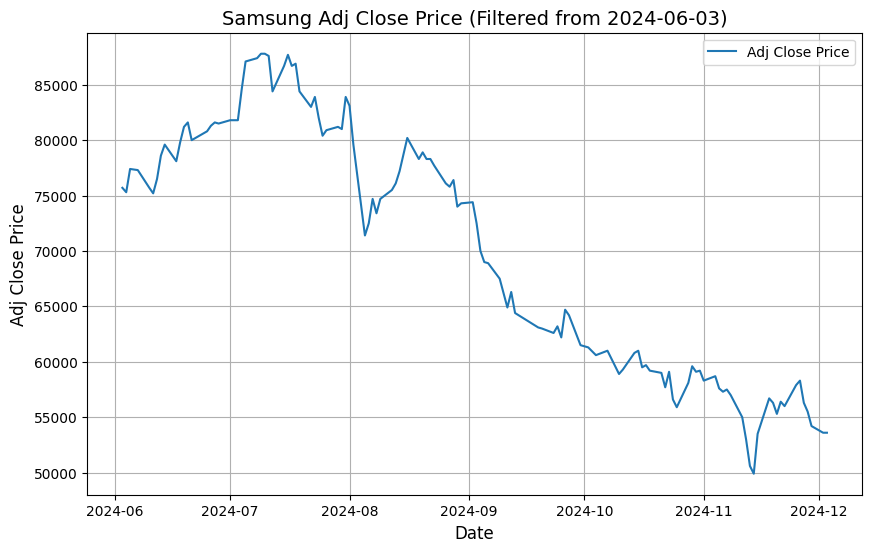

In [131]:
import matplotlib.pyplot as plt

# 2024-06-03 이후의 데이터 필터링
filtered_data = samsung_yf.loc['2024-06-03':'2024-12-03']

# 'Adj Close' 컬럼 선택
adj_close_values = filtered_data['Adj Close']

# 경로(Path) 그리기
plt.figure(figsize=(10, 6))
plt.plot(adj_close_values, marker='', linestyle='-', label='Adj Close Price')
plt.title('Samsung Adj Close Price (Filtered from 2024-06-03)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Adj Close Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [132]:
filtered_data

,Adj Close,ret,garch_vol_pred,ewma_vol_pred,roll_90_vol,10%_OTM_K,roll_63_vol,roll_126_vol,sell_imvol,sell_premium
trade_date,,,,,,,,,,
2024-06-03,75700,0.03,0.25,0.30,0.27,68130.00,0.30,0.25,0.29,11340.52
2024-06-04,75300,-0.01,0.25,0.29,0.26,67770.00,0.30,0.25,0.29,11280.33
2024-06-05,77400,0.03,0.25,0.30,0.27,69660.00,0.30,0.25,0.29,11623.68
2024-06-07,77300,-0.00,0.25,0.29,0.27,69570.00,0.30,0.25,0.29,11608.89
2024-06-10,75700,-0.02,0.25,0.29,0.27,68130.00,0.30,0.26,0.29,11402.82
...,...,...,...,...,...,...,...,...,...,...
2024-11-27,56300,-0.03,0.41,0.45,0.39,50670.00,0.37,0.37,0.43,10194.40
2024-11-28,55500,-0.01,0.40,0.44,0.39,49950.00,0.37,0.37,0.42,10021.17
2024-11-29,54200,-0.02,0.40,0.43,0.39,48780.00,0.37,0.37,0.42,9788.81


In [133]:
def hedge_cost_real_path(yf_data, start_date, t, M, flag, shares_per_opt, optbs, r, q, sigma_col):
    """
    실제 주가 경로(yf_data['Adj Close'])와 날짜별 변동성(sigma_col)을 사용하여 
    다이나믹 헷지를 수행하는 함수.
    
    잔여변동성 측정:
    각 헷지 시점마다 BSM 이론가와 누적 헷지 비용(cumulative_cost)의 차이를 측정하고,
    이 차이들의 표준편차를 잔여 변동성(Residual Volatility)로 정의한다.
    """

    # start_date 기준으로 행사가격 10% OTM K 가져오기
    X = yf_data.loc[start_date, '10%_OTM_K']

    # 사용 날짜 인덱스 생성
    all_dates = yf_data.loc[start_date:].index[:t+1]  # t+1개 행: start_date 포함
    # 주가 경로 및 변동성 추출
    adj_close_path = yf_data.loc[all_dates, 'Adj Close'].values
    sigmas = yf_data.loc[all_dates, sigma_col].values

    # 시작 시점 이론가: start_date의 sell_premium 사용
    theoretical_price = yf_data.loc[start_date, 'sell_premium'] * shares_per_opt
    s_start = adj_close_path[0]
    end_date = all_dates[-1]
    final_vol = yf_data.loc[end_date, 'roll_126_vol']
    t_a = t / 252.0  # 초기 만기시간(연 단위, 252거래일 가정)
    theoretical_price_realvol = bsprice(s_start, X, r, q, t_a, final_vol, flag) * shares_per_opt

    # 헷지 시점 정의
    hedge_points = list(range(0, t+1, M))
    if hedge_points[-1] != t:
        hedge_points.append(t)
    hedge_points = sorted(set(hedge_points))

    cumulative_cost = 0.0
    prev_delta = 0.0

    records = []

    # 잔여 오차 기록용 리스트
    residual_errors = []

    for idx, hp in enumerate(hedge_points):
        t_remaining = t - hp
        # 주석상 360일을 사용 중이었으나 앞서 252일 사용 -> 일관성 있게 252일 사용 권장
        # 여기서는 기존 코드 유지하되, 주석 수정:
        # tau = t_remaining / 360.0  # 원 코드 유지
        
        # tau = t_remaining / 360.0
        tau = t_remaining / 252 # 수정 by Jaepil

        s_current = adj_close_path[hp]
        current_sigma = sigmas[hp]

        # 만기 시점 델타 결정
        if hp == t:
            if flag.lower() == 'call':
                if s_current >= X:
                    current_delta = 1.0 if optbs.lower() == 'sell' else -1.0
                else:
                    current_delta = 0.0
            else: # put
                if s_current >= X:
                    current_delta = 0.0
                else:
                    current_delta = 1.0 if optbs.lower() == 'sell' else -1.0
        else:
            # 만기 전 델타 계산
            current_delta = delta(s_current, X, r, q, tau, current_sigma, flag)

        current_shares = current_delta * shares_per_opt
        prev_shares = prev_delta * shares_per_opt
        delta_change = current_shares - prev_shares

        # 거래 비용 계산
        if delta_change > 0:
            trade_cost = delta_change * s_current
        else:
            proceeds = (-delta_change) * s_current
            fee = 0.001 * proceeds
            net_inflow = proceeds - fee
            trade_cost = -net_inflow

        if idx > 0:
            delta_t = hp - hedge_points[idx-1]
            interest_cost = cumulative_cost * r * (delta_t / 360.0)
        else:
            interest_cost = 0.0

        cumulative_cost += (trade_cost + interest_cost)

        # 현재 시점 BSM 이론가 계산 (현재 주가, current_sigma, 남은 만기 tau)
        if tau > 0:
            current_theoretical = bsprice(s_current, X, r, q, tau, current_sigma, flag) * shares_per_opt
        else:
            # 만기일 경우 tau=0, 이론가는 내재가치
            intrinsic = max(s_current - X, 0) if flag.lower()=='call' else max(X - s_current, 0)
            current_theoretical = intrinsic * shares_per_opt

        # 잔여 오차: 이론가 - 누적헷지비용
        residual_error = current_theoretical - cumulative_cost
        residual_errors.append(residual_error)

        records.append({
            'date': all_dates[hp],
            's_current': s_current,
            'delta': current_delta,
            'delta_change': delta_change,
            'trade_cost': trade_cost,
            'interest_cost': interest_cost,
            'cumulative_cost': cumulative_cost,
            'current_theoretical': current_theoretical,
            'residual_error': residual_error
        })

        prev_delta = current_delta

    # 만기 시점 payoff 반영
    s_final = adj_close_path[-1]
    if flag.lower() == 'call':
        if s_final >= X:
            final_cost = cumulative_cost - X * shares_per_opt
        else:
            final_cost = cumulative_cost
    else:
        if s_final <= X:
            final_cost = X * shares_per_opt - cumulative_cost
        else:
            final_cost = cumulative_cost

    df_result = pd.DataFrame(records)

    # 잔여 변동성: residual_errors 표준편차
    residual_volatility = np.std(residual_errors)

    buyorsell = 1 if optbs.lower()=='sell' else -1
    hedging_pnl = buyorsell * (theoretical_price - final_cost)
    realvol_pnl = buyorsell * (theoretical_price - theoretical_price_realvol)

    results = []
    results.append([M, final_cost, hedging_pnl, theoretical_price, realvol_pnl, theoretical_price_realvol, residual_volatility])
    df = pd.DataFrame(results, columns=["Rebalancing Interval(days)", "hedge_cost", "hedging_pnl", 
                                        "theoretical_price", "realvol_pnl", "theoretical_price_realvol", "residual_volatility"])

    return cumulative_cost, final_cost, df_result, theoretical_price, df


In [134]:
samsung_yf

,Adj Close,ret,garch_vol_pred,ewma_vol_pred,roll_90_vol,10%_OTM_K,roll_63_vol,roll_126_vol,sell_imvol,sell_premium
trade_date,,,,,,,,,,
2022-01-04,78700,0.00,NaN,NaN,NaN,70830.00,NaN,NaN,NaN,NaN
2022-01-05,77400,-0.02,NaN,NaN,NaN,69660.00,NaN,NaN,NaN,NaN
2022-01-06,76900,-0.01,NaN,NaN,NaN,69210.00,NaN,NaN,NaN,NaN
2022-01-07,78300,0.02,NaN,NaN,NaN,70470.00,NaN,NaN,NaN,NaN
2022-01-10,78000,-0.00,NaN,NaN,NaN,70200.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-11-28,55500,-0.01,0.40,0.44,0.39,49950.00,0.37,0.37,0.42,10021.17
2024-11-29,54200,-0.02,0.40,0.43,0.39,48780.00,0.37,0.37,0.42,9788.81
2024-12-02,53600,-0.01,0.39,0.42,0.39,48240.00,0.37,0.37,0.42,9680.59


In [135]:
## 날짜 부족해서 시작일 수정
START_DATE_NEW = '2024-05-02'

cumulative_cost, final_cost, df_result, theoretical_price, df = hedge_cost_real_path(yf_data=samsung_yf, start_date=START_DATE_NEW, t=126, M=10, flag="call", shares_per_opt=100000, optbs="sell", r=0.04, q=0.00, sigma_col="garch_vol_pred")

In [136]:
df_result

,date,s_current,delta,delta_change,trade_cost,interest_cost,cumulative_cost,current_theoretical,residual_error
0,2024-05-02,78000,0.79,79430.30,6195563315.11,0.00,6195563315.11,1086164399.87,-5109398915.24
1,2024-05-20,78900,0.82,2300.02,181471853.43,6883959.24,6383919127.78,1137662926.96,-5246256200.82
2,2024-06-03,75700,0.74,-7391.54,-558980353.26,7093243.48,5832032017.99,871587268.47,-4960444749.52
3,2024-06-18,79800,0.84,10005.52,798440288.43,6480035.58,6636952342.00,1174252978.99,-5462699363.01
4,2024-07-02,81800,0.90,5444.99,445400524.26,7374391.49,7089727257.75,1313655924.96,-5776071332.79
5,2024-07-16,87700,0.96,6624.97,581009685.75,7877474.73,7678614418.23,1851944658.99,-5826669759.24
6,2024-07-30,81000,0.90,-6169.14,-499200982.53,8531793.80,7187945229.50,1202007567.32,-5985937662.19
7,2024-08-13,76100,0.81,-9674.72,-735509657.30,7986605.81,6460422178.02,748052159.78,-5712370018.23
8,2024-08-28,76400,0.84,3185.97,243408007.58,7178246.86,6711008432.46,738500961.71,-5972507470.75
9,2024-09-11,64900,0.29,-54448.18,-3530153061.98,7456676.04,3188312046.52,135520304.87,-3052791741.64


In [137]:
# 가정: hedge_cost_real_path 함수, samsung_yf DataFrame, 그리고 필요한 함수/모듈 이미 로드 완료

M_list = [1, 5, 10, 20, 30]
sigma_cols = ['garch_vol_pred', 'ewma_vol_pred', 'roll_90_vol', 'roll_63_vol', 'roll_126_vol']

# 결과를 저장할 리스트
results_all = []

for M_val in M_list:
    for sigma_val in sigma_cols:
        cumulative_cost, final_cost, df_result, theoretical_price, df = hedge_cost_real_path(
            yf_data=samsung_yf, 
            start_date=START_DATE_NEW, 
            t=126, 
            M=M_val, 
            flag="call", 
            shares_per_opt=100000, 
            optbs="sell", 
            r=0.04, 
            q=0.00, 
            sigma_col=sigma_val
        )
        
        # df에 어떤 M, sigma_col을 썼는지 표시하는 컬럼 추가
        df['M'] = M_val
        df['sigma_col'] = sigma_val
        
        # 리스트에 df 추가
        results_all.append(df)

# 모든 df를 하나의 DataFrame으로 합치기
final_results = pd.concat(results_all, ignore_index=True)

# final_results를 확인
final_results


,Rebalancing Interval(days),hedge_cost,hedging_pnl,theoretical_price,realvol_pnl,theoretical_price_realvol,residual_volatility,M,sigma_col
0,1,1330848316.06,-202997911.38,1127850404.68,-114728481.62,1242578886.30,1765254071.24,1,garch_vol_pred
1,1,1282324649.94,-154474245.26,1127850404.68,-114728481.62,1242578886.30,1605696705.15,1,ewma_vol_pred
2,1,1307023371.51,-179172966.83,1127850404.68,-114728481.62,1242578886.30,1622399201.00,1,roll_90_vol
3,1,1322966990.29,-195116585.61,1127850404.68,-114728481.62,1242578886.30,1576684906.77,1,roll_63_vol
4,1,1312400064.43,-184549659.75,1127850404.68,-114728481.62,1242578886.30,1682579437.13,1,roll_126_vol
5,5,1363314247.95,-235463843.27,1127850404.68,-114728481.62,1242578886.30,1822644565.87,5,garch_vol_pred
6,5,1306420281.85,-178569877.17,1127850404.68,-114728481.62,1242578886.30,1658856928.81,5,ewma_vol_pred
7,5,1298501551.29,-170651146.60,1127850404.68,-114728481.62,1242578886.30,1685987177.67,5,roll_90_vol
8,5,1328573995.86,-200723591.18,1127850404.68,-114728481.62,1242578886.30,1640362960.85,5,roll_63_vol
9,5,1317646967.57,-189796562.89,1127850404.68,-114728481.62,1242578886.30,1741403489.44,5,roll_126_vol


In [138]:
def hedge_cost_delta_band_real_path(yf_data, start_date, t, M, flag, shares_per_opt, optbs, r, q, sigma_col, delta_band=0.05):
    # start_date 기준으로 행사가격 10% OTM K 가져오기
    X = yf_data.loc[start_date, '10%_OTM_K']

    # 사용 날짜 인덱스 생성
    all_dates = yf_data.loc[start_date:].index[:t+1]  # t+1개 행: start_date 포함, start_date+ t일 뒤까지
    # 주가 경로 및 변동성 추출
    adj_close_path = yf_data.loc[all_dates, 'Adj Close'].values
    sigmas = yf_data.loc[all_dates, sigma_col].values

    # 이론가 대신 start_date의 sell_premium 사용
    theoretical_price = yf_data.loc[start_date, 'sell_premium'] * shares_per_opt
    # 이론가 대신 start_date의 sell_premium 사용
    theoretical_price = yf_data.loc[start_date, 'sell_premium'] * shares_per_opt
    s_start = adj_close_path[0]
    end_date = all_dates[-1]
    final_vol = yf_data.loc[end_date, 'roll_126_vol']
    t_a = t / 252.0  # 초기 만기시간 기준
    theoretical_price_realvol = bsprice(s_start, X, r, q, t_a, final_vol, flag) * shares_per_opt

    # 헷지 시점 정의
    hedge_points = list(range(0, t+1, M))
    if hedge_points[-1] != t:
        hedge_points.append(t)
    hedge_points = sorted(set(hedge_points))

    cumulative_cost = 0.0
    prev_delta = 0.0

    records = []

    for idx, hp in enumerate(hedge_points):
        t_remaining = t - hp
        tau = t_remaining / 360.0
        s_current = adj_close_path[hp]
        current_sigma = sigmas[hp]

        # 만기 시점 델타 결정
        if hp == t:
            if flag.lower() == 'call':
                if s_current >= X:
                    current_delta = 1.0 if optbs.lower()=='sell' else -1.0
                else:
                    current_delta = 0.0
            else: # put
                if s_current >= X:
                    current_delta = 0.0
                else:
                    current_delta = 1.0 if optbs.lower()=='sell' else -1.0
        else:
            # 만기 전 델타 계산 (BSM 델타)
            current_delta = delta(s_current, X, r, q, tau, current_sigma, flag)

        # 델타 밴드 체크
        if (abs(current_delta - prev_delta) > delta_band) or (hp == t):
            # 거래 수행
            current_shares = current_delta * shares_per_opt
            prev_shares = prev_delta * shares_per_opt
            delta_change = current_shares - prev_shares

            if delta_change > 0:
                trade_cost = delta_change * s_current
            else:
                proceeds = (-delta_change)*s_current
                fee = 0.001 * proceeds
                net_inflow = proceeds - fee
                trade_cost = -net_inflow

            if idx > 0:
                delta_t = hp - hedge_points[idx-1]
                interest_cost = cumulative_cost * r * (delta_t / 360.0)
            else:
                interest_cost = 0.0

            cumulative_cost += (trade_cost + interest_cost)
            prev_delta = current_delta
        else:
            # 거래 없음, 이자비용만
            if idx > 0:
                delta_t = hp - hedge_points[idx-1]
                interest_cost = cumulative_cost * r * (delta_t / 360.0)
            else:
                interest_cost = 0.0
            cumulative_cost += interest_cost

        records.append({
            'date': all_dates[hp],
            's_current': s_current,
            'delta': current_delta,
            'delta_change': (current_delta - prev_delta)*shares_per_opt if (abs(current_delta - prev_delta) > delta_band or hp == t) else 0,
            'trade_cost': trade_cost if (abs(current_delta - prev_delta) > delta_band or hp == t) else 0.0,
            'interest_cost': interest_cost,
            'cumulative_cost': cumulative_cost
        })

    # 만기 payoff 반영
    s_final = adj_close_path[-1]
    if flag.lower() == 'call':
        if s_final >= X:
            final_cost = cumulative_cost - X * shares_per_opt
        else:
            final_cost = cumulative_cost
    else:
        if s_final <= X:
            final_cost = X * shares_per_opt - cumulative_cost
        else:
            final_cost = cumulative_cost

    df_result = pd.DataFrame(records)

    buyorsell = 1 if optbs.lower()=='sell' else -1
    hedging_pnl = buyorsell * (theoretical_price - final_cost)
    realvol_pnl = buyorsell * (theoretical_price - theoretical_price_realvol)

    results = []
    results.append([M, final_cost, hedging_pnl, theoretical_price, realvol_pnl, theoretical_price_realvol])
    df = pd.DataFrame(results, columns=["Rebalancing Interval(days)", "hedge_cost", "hedging_pnl", "theoretical_price", "realvol_pnl", "theoretical_price_realvol"])

    return cumulative_cost, final_cost, df_result, theoretical_price, df




In [139]:
def hedge_cost_delta_gamma_band_real_path(yf_data, start_date, t, M, flag, shares_per_opt, optbs, r, q, sigma_col, delta_band=0.05, gamma_scale=10.0):
    # start_date 기준으로 행사가격 10% OTM K 가져오기
    X = yf_data.loc[start_date, '10%_OTM_K']

    # 사용 날짜 인덱스 생성
    all_dates = yf_data.loc[start_date:].index[:t+1]  # t+1개 행
    # 주가 경로 및 변동성 추출
    adj_close_path = yf_data.loc[all_dates, 'Adj Close'].values
    sigmas = yf_data.loc[all_dates, sigma_col].values

    # 이론가 대신 start_date의 sell_premium 사용
    theoretical_price = yf_data.loc[start_date, 'sell_premium'] * shares_per_opt
    # 이론가 대신 start_date의 sell_premium 사용
    theoretical_price = yf_data.loc[start_date, 'sell_premium'] * shares_per_opt
    s_start = adj_close_path[0]
    end_date = all_dates[-1]
    final_vol = yf_data.loc[end_date, 'roll_126_vol']
    t_a = t / 252.0  # 초기 만기시간 기준
    theoretical_price_realvol = bsprice(s_start, X, r, q, t_a, final_vol, flag) * shares_per_opt

    # 헷지 시점 정의
    hedge_points = list(range(0, t+1, M))
    if hedge_points[-1] != t:
        hedge_points.append(t)
    hedge_points = sorted(set(hedge_points))

    cumulative_cost = 0.0
    prev_delta = 0.0

    records = []

    for idx, hp in enumerate(hedge_points):
        t_remaining = t - hp
        tau = t_remaining / 252.0
        s_current = adj_close_path[hp]
        current_sigma = sigmas[hp]

        if hp == t:
            if flag.lower() == 'call':
                if s_current >= X:
                    current_delta = 1.0 if optbs.lower()=='sell' else -1.0
                else:
                    current_delta = 0.0
            else:
                if s_current >= X:
                    current_delta = 0.0
                else:
                    current_delta = 1.0 if optbs.lower()=='sell' else -1.0
            effective_delta_band = 0.0
        else:
            current_delta = delta(s_current, X, r, q, tau, current_sigma, flag)
            current_gamma = gamma(s_current, X, r, q, tau, current_sigma, flag)
            effective_delta_band = delta_band / (1.0 + gamma_scale * current_gamma)

        if (abs(current_delta - prev_delta) > effective_delta_band) or (hp == t):
            current_shares = current_delta * shares_per_opt
            prev_shares = prev_delta * shares_per_opt
            delta_change = current_shares - prev_shares

            if delta_change > 0:
                trade_cost = delta_change * s_current
            else:
                proceeds = (-delta_change)*s_current
                fee = 0.001 * proceeds
                net_inflow = proceeds - fee
                trade_cost = -net_inflow

            if idx > 0:
                delta_t = hp - hedge_points[idx-1]
                interest_cost = cumulative_cost * r * (delta_t / 360.0)
            else:
                interest_cost = 0.0

            cumulative_cost += (trade_cost + interest_cost)
            prev_delta = current_delta
        else:
            # 거래 없음
            if idx > 0:
                delta_t = hp - hedge_points[idx-1]
                interest_cost = cumulative_cost * r * (delta_t / 360.0)
            else:
                interest_cost = 0.0
            cumulative_cost += interest_cost
            trade_cost = 0.0
            delta_change = 0.0

        records.append({
            'date': all_dates[hp],
            's_current': s_current,
            'delta': current_delta,
            'delta_change': delta_change,
            'trade_cost': trade_cost,
            'interest_cost': interest_cost,
            'cumulative_cost': cumulative_cost
        })

    s_final = adj_close_path[-1]
    if flag.lower() == 'call':
        if s_final >= X:
            final_cost = cumulative_cost - X * shares_per_opt
        else:
            final_cost = cumulative_cost
    else:
        if s_final <= X:
            final_cost = X * shares_per_opt - cumulative_cost
        else:
            final_cost = cumulative_cost

    df_result = pd.DataFrame(records)

    buyorsell = 1 if optbs.lower()=='sell' else -1
    hedging_pnl = buyorsell * (theoretical_price - final_cost)
    realvol_pnl = buyorsell * (theoretical_price - theoretical_price_realvol)

    results = []
    results.append([M, final_cost, hedging_pnl, theoretical_price, realvol_pnl, theoretical_price_realvol])
    df = pd.DataFrame(results, columns=["Rebalancing Interval(days)", "hedge_cost", "hedging_pnl", "theoretical_price", "realvol_pnl", "theoretical_price_realvol"])

    return cumulative_cost, final_cost, df_result, theoretical_price, df


In [140]:
cumulative_cost, final_cost, df_result, theoretical_price, df = hedge_cost_delta_band_real_path(yf_data=samsung_yf, start_date=START_DATE_NEW, t=126, M=10, flag="call", shares_per_opt=100000, optbs="sell", r=0.04, q=0.00, sigma_col="roll_126_vol")

In [141]:
df

,Rebalancing Interval(days),hedge_cost,hedging_pnl,theoretical_price,realvol_pnl,theoretical_price_realvol
0,10,1352260635.86,-224410231.18,1127850404.68,-114728481.62,1242578886.30


In [142]:
results_all = []

for M_val in M_list:
    for sigma_val in sigma_cols:
        cumulative_cost, final_cost, df_result, theoretical_price, df = hedge_cost_delta_band_real_path(
            yf_data=samsung_yf, 
            start_date=START_DATE_NEW, 
            t=126, 
            M=M_val, 
            flag="call", 
            shares_per_opt=100000, 
            optbs="sell", 
            r=0.04, 
            q=0.00, 
            sigma_col=sigma_val
        )
        
        # df에 어떤 M, sigma_col을 썼는지 표시하는 컬럼 추가
        df['M'] = M_val
        df['sigma_col'] = sigma_val
        
        # 리스트에 df 추가
        results_all.append(df)

# 모든 df를 하나의 DataFrame으로 합치기
final_results = pd.concat(results_all, ignore_index=True)

# final_results를 확인
final_results

,Rebalancing Interval(days),hedge_cost,hedging_pnl,theoretical_price,realvol_pnl,theoretical_price_realvol,M,sigma_col
0,1,1277198312.32,-149347907.64,1127850404.68,-114728481.62,1242578886.30,1,garch_vol_pred
1,1,1278821508.76,-150971104.08,1127850404.68,-114728481.62,1242578886.30,1,ewma_vol_pred
2,1,1326539067.11,-198688662.43,1127850404.68,-114728481.62,1242578886.30,1,roll_90_vol
3,1,1323006174.63,-195155769.95,1127850404.68,-114728481.62,1242578886.30,1,roll_63_vol
4,1,1298001113.33,-170150708.65,1127850404.68,-114728481.62,1242578886.30,1,roll_126_vol
5,5,1444896478.99,-317046074.31,1127850404.68,-114728481.62,1242578886.30,5,garch_vol_pred
6,5,1319273232.68,-191422828.00,1127850404.68,-114728481.62,1242578886.30,5,ewma_vol_pred
7,5,1375571864.41,-247721459.72,1127850404.68,-114728481.62,1242578886.30,5,roll_90_vol
8,5,1373729386.83,-245878982.15,1127850404.68,-114728481.62,1242578886.30,5,roll_63_vol
9,5,1376170992.97,-248320588.29,1127850404.68,-114728481.62,1242578886.30,5,roll_126_vol


In [143]:
cumulative_cost, final_cost, df_result, theoretical_price, df = hedge_cost_delta_gamma_band_real_path(yf_data=samsung_yf, start_date=START_DATE_NEW, t=126, M=10, flag="call", shares_per_opt=100000, optbs="sell", r=0.04, q=0.00, sigma_col="roll_126_vol")

In [144]:
df

,Rebalancing Interval(days),hedge_cost,hedging_pnl,theoretical_price,realvol_pnl,theoretical_price_realvol
0,10,1347055201.40,-219204796.72,1127850404.68,-114728481.62,1242578886.30


In [145]:
results_all = []

for M_val in M_list:
    for sigma_val in sigma_cols:
        cumulative_cost, final_cost, df_result, theoretical_price, df = hedge_cost_delta_gamma_band_real_path(
            yf_data=samsung_yf, 
            start_date=START_DATE_NEW, 
            t=126, 
            M=M_val, 
            flag="call", 
            shares_per_opt=100000, 
            optbs="sell", 
            r=0.04, 
            q=0.00, 
            sigma_col=sigma_val
        )
        
        # df에 어떤 M, sigma_col을 썼는지 표시하는 컬럼 추가
        df['M'] = M_val
        df['sigma_col'] = sigma_val
        
        # 리스트에 df 추가
        results_all.append(df)

# 모든 df를 하나의 DataFrame으로 합치기
final_results = pd.concat(results_all, ignore_index=True)

# final_results를 확인
final_results

,Rebalancing Interval(days),hedge_cost,hedging_pnl,theoretical_price,realvol_pnl,theoretical_price_realvol,M,sigma_col
0,1,1308625527.64,-180775122.96,1127850404.68,-114728481.62,1242578886.30,1,garch_vol_pred
1,1,1270472796.09,-142622391.41,1127850404.68,-114728481.62,1242578886.30,1,ewma_vol_pred
2,1,1324030738.88,-196180334.20,1127850404.68,-114728481.62,1242578886.30,1,roll_90_vol
3,1,1336828835.87,-208978431.19,1127850404.68,-114728481.62,1242578886.30,1,roll_63_vol
4,1,1290530057.30,-162679652.62,1127850404.68,-114728481.62,1242578886.30,1,roll_126_vol
5,5,1394046858.46,-266196453.78,1127850404.68,-114728481.62,1242578886.30,5,garch_vol_pred
6,5,1350491861.33,-222641456.65,1127850404.68,-114728481.62,1242578886.30,5,ewma_vol_pred
7,5,1362648296.11,-234797891.43,1127850404.68,-114728481.62,1242578886.30,5,roll_90_vol
8,5,1365418719.84,-237568315.16,1127850404.68,-114728481.62,1242578886.30,5,roll_63_vol
9,5,1377884021.78,-250033617.10,1127850404.68,-114728481.62,1242578886.30,5,roll_126_vol


In [146]:
BENCHMARK_HEDGE_COST = final_results.sort_values('hedge_cost').iloc[0]['hedge_cost']
BENCHMARK_HEDGE_COST

1224492784.9093528

## 재필 모멘텀 시그널 추가

In [147]:
samsung_signals = pd.read_pickle(OUTPUT_PATH / 'samsung_df.pkl')
samsung_signals = samsung_signals[
    [
        'mom10',
        'mom9',
        'mom7',
    ]
].copy()

new_samsung_yf = samsung_yf.copy()
new_samsung_yf = new_samsung_yf.join(samsung_signals)

In [154]:
def hedge_cost_delta_gamma_band_real_path_temp(yf_data, start_date, t, M, flag, shares_per_opt, optbs, r, q, sigma_col, delta_band=0.05):
    # start_date 기준으로 행사가격 10% OTM K 가져오기
    X = yf_data.loc[start_date, '10%_OTM_K']

    # 사용 날짜 인덱스 생성
    all_dates = yf_data.loc[start_date:].index[:t+1]  # t+1개 행
    # 주가 경로 및 변동성 추출
    adj_close_path = yf_data.loc[all_dates, 'Adj Close'].values
    sigmas = yf_data.loc[all_dates, sigma_col].values

    # 이론가 대신 start_date의 sell_premium 사용
    theoretical_price = yf_data.loc[start_date, 'sell_premium'] * shares_per_opt
    # 이론가 대신 start_date의 sell_premium 사용
    theoretical_price = yf_data.loc[start_date, 'sell_premium'] * shares_per_opt
    s_start = adj_close_path[0]
    end_date = all_dates[-1]
    final_vol = yf_data.loc[end_date, 'roll_126_vol']
    t_a = t / 252.0  # 초기 만기시간 기준
    theoretical_price_realvol = bsprice(s_start, X, r, q, t_a, final_vol, flag) * shares_per_opt


    ### 모멘텀 시그널들
    signal1 = yf_data.loc[all_dates, 'mom10'].values
    signal2 = yf_data.loc[all_dates, 'mom9'].values
    signal3 = yf_data.loc[all_dates, 'mom7'].values


    # 헷지 시점 정의
    hedge_points = list(range(0, t+1, M))
    if hedge_points[-1] != t:
        hedge_points.append(t)
    hedge_points = sorted(set(hedge_points))


    def hedge(edb_func=None):

        cumulative_cost = 0.0
        prev_delta = 0.0

        records = []

        for idx, hp in enumerate(hedge_points):
            t_remaining = t - hp
            tau = t_remaining / 252.0
            s_current = adj_close_path[hp]
            current_sigma = sigmas[hp]

            ## 재필 시그널들
            signal1_current = signal1[hp]
            signal2_current = signal2[hp]
            signal3_current = signal3[hp]

            if hp == t:
                if flag.lower() == 'call':
                    if s_current >= X:
                        current_delta = 1.0 if optbs.lower()=='sell' else -1.0
                    else:
                        current_delta = 0.0
                else:
                    if s_current >= X:
                        current_delta = 0.0
                    else:
                        current_delta = 1.0 if optbs.lower()=='sell' else -1.0
                effective_delta_band = 0.0
            else:
                current_delta = delta(s_current, X, r, q, tau, current_sigma, flag)
                current_gamma = gamma(s_current, X, r, q, tau, current_sigma, flag)

                ### Signal 추가하는 부분
                effective_delta_band = delta_band / (1.0 + current_sigma * current_gamma)

            if (abs(current_delta - prev_delta) > effective_delta_band) or (hp == t):
                current_shares = current_delta * shares_per_opt
                prev_shares = prev_delta * shares_per_opt
                delta_change = current_shares - prev_shares

                if delta_change > 0:
                    trade_cost = delta_change * s_current
                else:
                    proceeds = (-delta_change)*s_current
                    fee = 0.001 * proceeds
                    net_inflow = proceeds - fee
                    trade_cost = -net_inflow

                if idx > 0:
                    delta_t = hp - hedge_points[idx-1]
                    interest_cost = cumulative_cost * r * (delta_t / 360.0)
                else:
                    interest_cost = 0.0

                cumulative_cost += (trade_cost + interest_cost)
                prev_delta = current_delta
            else:
                # 거래 없음
                if idx > 0:
                    delta_t = hp - hedge_points[idx-1]
                    interest_cost = cumulative_cost * r * (delta_t / 360.0)
                else:
                    interest_cost = 0.0
                cumulative_cost += interest_cost
                trade_cost = 0.0
                delta_change = 0.0

            records.append({
                'date': all_dates[hp],
                's_current': s_current,
                'delta': current_delta,
                'delta_change': delta_change,
                'trade_cost': trade_cost,
                'interest_cost': interest_cost,
                'cumulative_cost': cumulative_cost
            })


        s_final = adj_close_path[-1]
        if flag.lower() == 'call':
            if s_final >= X:
                final_cost = cumulative_cost - X * shares_per_opt
            else:
                final_cost = cumulative_cost
        else:
            if s_final <= X:
                final_cost = X * shares_per_opt - cumulative_cost
            else:
                final_cost = cumulative_cost

        df_result = pd.DataFrame(records)

        buyorsell = 1 if optbs.lower()=='sell' else -1
        hedging_pnl = buyorsell * (theoretical_price - final_cost)
        realvol_pnl = buyorsell * (theoretical_price - theoretical_price_realvol)

        results = []
        results.append([M, final_cost, hedging_pnl, theoretical_price, realvol_pnl, theoretical_price_realvol])
        df = pd.DataFrame(results, columns=["Rebalancing Interval(days)", "hedge_cost", "hedging_pnl", "theoretical_price", "realvol_pnl", "theoretical_price_realvol"])

        return cumulative_cost, final_cost, df_result, theoretical_price, df
    
    return hedge()

    # _, _, _, _, df = hedge()

    # return df


In [155]:
def hedge_cost_delta_gamma_band_real_path_temp(yf_data, start_date, t, M, flag, shares_per_opt, optbs, r, q, sigma_col, delta_band=0.05):
    # start_date 기준으로 행사가격 10% OTM K 가져오기
    X = yf_data.loc[start_date, '10%_OTM_K']

    # 사용 날짜 인덱스 생성
    all_dates = yf_data.loc[start_date:].index[:t+1]  # t+1개 행
    # 주가 경로 및 변동성 추출
    adj_close_path = yf_data.loc[all_dates, 'Adj Close'].values
    sigmas = yf_data.loc[all_dates, sigma_col].values

    # 이론가 대신 start_date의 sell_premium 사용
    theoretical_price = yf_data.loc[start_date, 'sell_premium'] * shares_per_opt
    # 이론가 대신 start_date의 sell_premium 사용
    theoretical_price = yf_data.loc[start_date, 'sell_premium'] * shares_per_opt
    s_start = adj_close_path[0]
    end_date = all_dates[-1]
    final_vol = yf_data.loc[end_date, 'roll_126_vol']
    t_a = t / 252.0  # 초기 만기시간 기준
    theoretical_price_realvol = bsprice(s_start, X, r, q, t_a, final_vol, flag) * shares_per_opt

    # 헷지 시점 정의
    hedge_points = list(range(0, t+1, M))
    if hedge_points[-1] != t:
        hedge_points.append(t)
    hedge_points = sorted(set(hedge_points))

    cumulative_cost = 0.0
    prev_delta = 0.0

    records = []

    for idx, hp in enumerate(hedge_points):
        t_remaining = t - hp
        tau = t_remaining / 252.0
        s_current = adj_close_path[hp]
        current_sigma = sigmas[hp]

        if hp == t:
            if flag.lower() == 'call':
                if s_current >= X:
                    current_delta = 1.0 if optbs.lower()=='sell' else -1.0
                else:
                    current_delta = 0.0
            else:
                if s_current >= X:
                    current_delta = 0.0
                else:
                    current_delta = 1.0 if optbs.lower()=='sell' else -1.0
            effective_delta_band = 0.0
        else:
            current_delta = delta(s_current, X, r, q, tau, current_sigma, flag)
            current_gamma = gamma(s_current, X, r, q, tau, current_sigma, flag)
            effective_delta_band = delta_band / (1.0 + current_sigma * current_gamma)

        if (abs(current_delta - prev_delta) > effective_delta_band) or (hp == t):
            current_shares = current_delta * shares_per_opt
            prev_shares = prev_delta * shares_per_opt
            delta_change = current_shares - prev_shares

            if delta_change > 0:
                trade_cost = delta_change * s_current
            else:
                proceeds = (-delta_change)*s_current
                fee = 0.001 * proceeds
                net_inflow = proceeds - fee
                trade_cost = -net_inflow

            if idx > 0:
                delta_t = hp - hedge_points[idx-1]
                interest_cost = cumulative_cost * r * (delta_t / 360.0)
            else:
                interest_cost = 0.0

            cumulative_cost += (trade_cost + interest_cost)
            prev_delta = current_delta
        else:
            # 거래 없음
            if idx > 0:
                delta_t = hp - hedge_points[idx-1]
                interest_cost = cumulative_cost * r * (delta_t / 360.0)
            else:
                interest_cost = 0.0
            cumulative_cost += interest_cost
            trade_cost = 0.0
            delta_change = 0.0

        records.append({
            'date': all_dates[hp],
            's_current': s_current,
            'delta': current_delta,
            'delta_change': delta_change,
            'trade_cost': trade_cost,
            'interest_cost': interest_cost,
            'cumulative_cost': cumulative_cost
        })

    s_final = adj_close_path[-1]
    if flag.lower() == 'call':
        if s_final >= X:
            final_cost = cumulative_cost - X * shares_per_opt
        else:
            final_cost = cumulative_cost
    else:
        if s_final <= X:
            final_cost = X * shares_per_opt - cumulative_cost
        else:
            final_cost = cumulative_cost

    df_result = pd.DataFrame(records)

    buyorsell = 1 if optbs.lower()=='sell' else -1
    hedging_pnl = buyorsell * (theoretical_price - final_cost)
    realvol_pnl = buyorsell * (theoretical_price - theoretical_price_realvol)

    results = []
    results.append([M, final_cost, hedging_pnl, theoretical_price, realvol_pnl, theoretical_price_realvol])
    df = pd.DataFrame(results, columns=["Rebalancing Interval(days)", "hedge_cost", "hedging_pnl", "theoretical_price", "realvol_pnl", "theoretical_price_realvol"])

    return cumulative_cost, final_cost, df_result, theoretical_price, df


In [156]:
results_all = []

for M_val in M_list:
    for sigma_val in sigma_cols:
        cumulative_cost, final_cost, df_result, theoretical_price, df = hedge_cost_delta_gamma_band_real_path_temp(
            yf_data=new_samsung_yf, 
            start_date=START_DATE_NEW, 
            t=126, 
            M=M_val, 
            flag="call", 
            shares_per_opt=100000, 
            optbs="sell", 
            r=0.04, 
            q=0.00, 
            sigma_col=sigma_val
        )
        
        # df에 어떤 M, sigma_col을 썼는지 표시하는 컬럼 추가
        df['M'] = M_val
        df['sigma_col'] = sigma_val
        
        # 리스트에 df 추가
        results_all.append(df)

# 모든 df를 하나의 DataFrame으로 합치기
final_results = pd.concat(results_all, ignore_index=True)

# final_results를 확인
final_results

,Rebalancing Interval(days),hedge_cost,hedging_pnl,theoretical_price,realvol_pnl,theoretical_price_realvol,M,sigma_col
0,1,1308625527.64,-180775122.96,1127850404.68,-114728481.62,1242578886.30,1,garch_vol_pred
1,1,1270472796.09,-142622391.41,1127850404.68,-114728481.62,1242578886.30,1,ewma_vol_pred
2,1,1324030738.88,-196180334.20,1127850404.68,-114728481.62,1242578886.30,1,roll_90_vol
3,1,1336828835.87,-208978431.19,1127850404.68,-114728481.62,1242578886.30,1,roll_63_vol
4,1,1290530057.30,-162679652.62,1127850404.68,-114728481.62,1242578886.30,1,roll_126_vol
5,5,1394046858.46,-266196453.78,1127850404.68,-114728481.62,1242578886.30,5,garch_vol_pred
6,5,1350491861.33,-222641456.65,1127850404.68,-114728481.62,1242578886.30,5,ewma_vol_pred
7,5,1362648296.11,-234797891.43,1127850404.68,-114728481.62,1242578886.30,5,roll_90_vol
8,5,1365418719.84,-237568315.16,1127850404.68,-114728481.62,1242578886.30,5,roll_63_vol
9,5,1377884021.78,-250033617.10,1127850404.68,-114728481.62,1242578886.30,5,roll_126_vol


In [153]:
comparison = final_results.sort_values('hedge_cost', ascending=True).copy()
comparison['benchmark_hedge_cost'] = BENCHMARK_HEDGE_COST
comparison['cost_diff'] = comparison['hedge_cost'] - comparison['benchmark_hedge_cost']
comparison

,Rebalancing Interval(days),hedge_cost,hedging_pnl,theoretical_price,realvol_pnl,theoretical_price_realvol,M,sigma_col,benchmark_hedge_cost,cost_diff
11,10,1224492784.91,-96642380.23,1127850404.68,-114728481.62,1242578886.30,10,ewma_vol_pred,1224492784.91,0.00
1,1,1270472796.09,-142622391.41,1127850404.68,-114728481.62,1242578886.30,1,ewma_vol_pred,1224492784.91,45980011.18
4,1,1290530057.30,-162679652.62,1127850404.68,-114728481.62,1242578886.30,1,roll_126_vol,1224492784.91,66037272.39
0,1,1308625527.64,-180775122.96,1127850404.68,-114728481.62,1242578886.30,1,garch_vol_pred,1224492784.91,84132742.73
13,10,1321712183.30,-193861778.62,1127850404.68,-114728481.62,1242578886.30,10,roll_63_vol,1224492784.91,97219398.39
2,1,1324030738.88,-196180334.20,1127850404.68,-114728481.62,1242578886.30,1,roll_90_vol,1224492784.91,99537953.97
12,10,1333111268.56,-205260863.88,1127850404.68,-114728481.62,1242578886.30,10,roll_90_vol,1224492784.91,108618483.65
3,1,1336828835.87,-208978431.19,1127850404.68,-114728481.62,1242578886.30,1,roll_63_vol,1224492784.91,112336050.96
14,10,1347055201.40,-219204796.72,1127850404.68,-114728481.62,1242578886.30,10,roll_126_vol,1224492784.91,122562416.49
6,5,1350491861.33,-222641456.65,1127850404.68,-114728481.62,1242578886.30,5,ewma_vol_pred,1224492784.91,125999076.42
